In [186]:
# Imports
import twint
import nest_asyncio
import numpy as np
import pandas as pa
import sklearn as sk
import keras 
import tensorflow as tf
import json
from pandas_datareader import data
from datetime import datetime
from datetime import timedelta  
from pandas.tseries.holiday import USFederalHolidayCalendar
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils

import re
import string

# NLP Packages
import nltk
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.tokenize import word_tokenize

nltk.download('punkt')
nltk.download('vader_lexicon')
nltk.download('stopwords')

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_score, recall_score, plot_roc_curve
from sklearn.linear_model import LogisticRegression
import scikitplot
import matplotlib.pyplot as plt

from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm


# This ensures the twint loop can run in jupyter notebook, no need to understand it
nest_asyncio.apply()
pa.set_option('display.max_colwidth', None)

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/suryasundaram/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/suryasundaram/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/suryasundaram/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [116]:
# Predetermined Parameters (adjust for each stock manually)
user = "elonmusk"
tckr = "TSLA"

In [117]:
# Read in stock data from premade excel file (adjust for each stock)
stock_data = pa.read_excel('Tesla_Prices.xlsx', usecols=[0,1]) 
  
stock_data

Date  Last Price
0    2020-11-30 15:00:00    584.4363
1    2020-11-30 14:30:00    584.0701
2    2020-11-30 14:00:00    580.1600
3    2020-11-30 13:30:00    580.2796
4    2020-11-30 13:00:00    580.1000
...                  ...         ...
2356 2020-03-13 11:30:00    103.7550
2357 2020-03-13 11:00:00    106.0960
2358 2020-03-13 10:30:00    109.8840
2359 2020-03-13 10:00:00    113.7220
2360 2020-03-13 09:30:00    112.4337

[2361 rows x 2 columns]

In [118]:
# Use twint to grab tweets and put into pandas dataframe
c = twint.Config()

c.Username = user
# I don't think the following line is neccessary as inputting to pandas gives us all columns by default
c.Custom["tweet"] = ["id", "username", "created_at", "username", "mentions" , "replies_count", "retweets_count", "likes_count", "hashtags", "tweet"]
c.Pandas = True

twint.run.Search(c)

Tweets_df = twint.storage.panda.Tweets_df

1334321901783511041 2020-12-02 21:21:46 -0500 <elonmusk> @ErcXspace @SpaceX @NASASpaceflight @Erdayastronaut @MarcusHouseGame @FelixSchlang Not bad
1334188934545481730 2020-12-02 12:33:24 -0500 <elonmusk> @TheOnion It was a beast compared to the VIC-20
1334127507906314240 2020-12-02 08:29:19 -0500 <elonmusk> @Tesmanian_com Award accepted on behalf of the great people at Tesla, SpaceX, Neuralink &amp; Boring Co
1333974035294683137 2020-12-01 22:19:28 -0500 <elonmusk> Much of what people think of an science is actually engineering, eg no such thing as a “rocket scientist”, only rocket engineers. Latter is who put humans on the moon.
1333972511524995072 2020-12-01 22:13:25 -0500 <elonmusk> Science is discovering the essential truths about what exists in the Universe, engineering is about creating things that never existed  https://t.co/aIEUtHoPxM
1333969911790456833 2020-12-01 22:03:05 -0500 <elonmusk> @justpaulinelol It does get a bit cold at night
1333742310388064256 2020-12-01 06:58:41

1329114904817758208 2020-11-18 12:31:01 -0500 <elonmusk> @garyblack00 Wise words from Bogle. The point of companies is products &amp; services. They have no point in &amp; of themselves, nor do these indices. Buy &amp; hold stock in companies where you love the product roadmap, sell where you don’t.  https://t.co/yHVQJXTahn
1329103547397496834 2020-11-18 11:45:53 -0500 <elonmusk> @teslaownerssv @AstroJordy @flcnhvy No, just a mild cold. Same with my bro. Def had cov2 though. Pc&lt;20 means viral load of &gt;10 million per mL.
1329102718988922883 2020-11-18 11:42:36 -0500 <elonmusk> @Astronomiaum Life in glass domes at first. Eventually, terraformed to support life, like Earth.
1329099418306482179 2020-11-18 11:29:29 -0500 <elonmusk> @AstroJordy @flcnhvy Yeah
1329094473561894913 2020-11-18 11:09:50 -0500 <elonmusk> @Daywalker_xD @Astronomiaum I was going to say “Sim!”, but that seemed too obvious haha
1329088067370590208 2020-11-18 10:44:23 -0500 <elonmusk> @Astronomiaum Deveras!
132897

1327224089451196420 2020-11-13 07:17:36 -0500 <elonmusk> @PPathole @cleantechnica A good PCR test should identify if I have the cov2 spike proteins, although I have heard some low accuracy numbers for those too. Hard to get a straight answer.   False positives will roughly scale with # of tests &amp; daily test rate has gone ballistic:  https://t.co/Pv6s71jZQo
1327210365713743872 2020-11-13 06:23:04 -0500 <elonmusk> @justpaulinelol @cleantechnica Mild sniffles &amp; cough &amp; slight fever past few days. Right now, no symptoms, although I did take NyQuil.
1327208777049804800 2020-11-13 06:16:45 -0500 <elonmusk> @cleantechnica Technically, I tested positive, then negative twice, then positive again, so “Elon Musk Tests Negative for Covid” is an equally correct title. The “rapid antigen test” from BD seems to be about as useful as a flipping a coin.
1327132071370878976 2020-11-13 01:11:57 -0500 <elonmusk> The carousel turns ever faster
1327131163622854657 2020-11-13 01:08:20 -0500 <elon

1322342760343461888 2020-10-30 21:00:56 -0500 <elonmusk> @RationalEtienne @teslaownersSV @toadmeister Yes
1322338101654511617 2020-10-30 20:42:25 -0500 <elonmusk> @teslaownersSV @toadmeister I’ve spent more than half my life in California &amp; love the state. But, frankly, I think CA has the winning-for-too-long problem.   Like a sports team with many championships, it is increasingly difficult to avoid complacency &amp; a sense of entitlement.
1322336364478623749 2020-10-30 20:35:31 -0500 <elonmusk> @toadmeister And … Sweden is still right with zero deaths Oct 29  https://t.co/b0LyGOtobI
1322334997282394112 2020-10-30 20:30:05 -0500 <elonmusk> @TOCNewYorkState True. Also, fewer heart attacks, as way easier to pump blood in 37% gravity.
1322334523275685888 2020-10-30 20:28:12 -0500 <elonmusk> @MalekKhelifi24 @9inety6Prince @engineers_feed Now we’re talking. Also, Stephenson 2-18 is in the constellation Scrotum haha.
1322309226228641792 2020-10-30 18:47:41 -0500 <elonmusk> @engineers_f

1316455272467005443 2020-10-14 15:06:10 -0500 <elonmusk> @kimpaquette Yes
1316454693489516545 2020-10-14 15:03:52 -0500 <elonmusk> @teslaownersSV Starting production on 7 seater next month, initial deliveries early December
1316454051693895680 2020-10-14 15:01:19 -0500 <elonmusk> The gauntlet has been thrown down!   The prophecy will be fulfilled.   Model S price changes to $69,420 tonight!
1316442326777110536 2020-10-14 14:14:43 -0500 <elonmusk> @Neopork85 @SpaceX @NASASpaceflight @austinbarnard45 @whoisheartbreak @Erdayastronaut @FelixSchlang @MarcusHouseGame @SpaceToday1 More great renderings! Significant improvements coming to the welds.
1316440688234508294 2020-10-14 14:08:13 -0500 <elonmusk> @gem8mingen @Tesla Congratulations!
1316434397525049349 2020-10-14 13:43:13 -0500 <elonmusk> @Teslarati Making progress
1316309830756425734 2020-10-14 05:28:14 -0500 <elonmusk> 9 meter or roughly 30 ft diameter
1316308998283460609 2020-10-14 05:24:55 -0500 <elonmusk> Will be less roomy with 3

1313864611997855744 2020-10-07 11:31:48 -0500 <elonmusk> @raytech247 @WholeMarsBlog Even GM &amp; Chrysler went bankrupt in 2009. Ford and Tesla are the only US car companies that have avoided bankruptcy.
1313864182350204928 2020-10-07 11:30:06 -0500 <elonmusk> @raytech247 @WholeMarsBlog The Model 3 production ramp was sheer agony for two years, but that was do or die for Tesla. No US car company has reached high volume production with sustained free cash flow in ~100 years. Hundreds of car startups all died or were absorbed for peanuts by big three.
1313861394257899520 2020-10-07 11:19:01 -0500 <elonmusk> @EvaFoxU @WholeMarsBlog Bringing a new product to volume production is 1% inspiration &amp; 99% perspiration. You do still need that critical seed of inspiration, but it’s fun &amp; takes ~100 people. Production takes &gt;10,000 people &amp; hurts like hell until the gigantic cybernetic collective runs smoothly.
1313858597428826120 2020-10-07 11:07:54 -0500 <elonmusk> @skorusARK Marg

1309916454616145920 2020-09-26 14:03:14 -0500 <elonmusk> @flcnhvy @NASASpaceflight @austinbarnard45 @PPathole Mostly 304L, some 301. Broke at 301 to 304 interface. SN9 will be all 304. Also, we’re making some tweaks to the 304 alloy mixture.
1309915379041402881 2020-09-26 13:58:58 -0500 <elonmusk> @NASASpaceflight @austinbarnard45 @PPathole 8 bar differential in ullage, 9 bar at base due to propellant head. It’s enough. Improvements in work.
1309912233921531905 2020-09-26 13:46:28 -0500 <elonmusk> @PPathole We just need enough height to test body flaps &amp; drawing propellant from headers vs main tanks. Will do several flights to confirm working well, then add heat shield &amp; go high Mach.
1309910946219876353 2020-09-26 13:41:21 -0500 <elonmusk> First flight is to 15km or ~50,000 ft
1309910141140049921 2020-09-26 13:38:09 -0500 <elonmusk> Nosecone &amp; front flaps next week. SN9 next month.
1309909732954533889 2020-09-26 13:36:31 -0500 <elonmusk> Starship SN8 with rear body flaps  

1306131538694684672 2020-09-16 03:23:20 -0500 <elonmusk> @JohnnaCrider1 @jhall They remind me of these guys  https://t.co/Qt502U08np
1305978108240068613 2020-09-15 17:13:39 -0500 <elonmusk> Story of my life
1305977917843873799 2020-09-15 17:12:54 -0500 <elonmusk>  https://t.co/Vn0Rv0yQ5q
1305967030701613059 2020-09-15 16:29:38 -0500 <elonmusk> Tunnels under cities with self-driving electric cars will feel like warp drive  First operational tunnel under Vegas almost done  The @BoringCompany
1305964219066658816 2020-09-15 16:18:28 -0500 <elonmusk> @jackfarrington For sure
1305963993165697026 2020-09-15 16:17:34 -0500 <elonmusk> @jackfarrington @Tesla Good point
1305963097207734273 2020-09-15 16:14:00 -0500 <elonmusk> Have you hugged a tunnel today?
1305961297608089601 2020-09-15 16:06:51 -0500 <elonmusk> @ARKInvest @aurmanARK Good analysis
1305906872436903936 2020-09-15 12:30:35 -0500 <elonmusk> @PPathole Exactly
1305902271239270400 2020-09-15 12:12:18 -0500 <elonmusk> @flcnhvy Gary the 

1300102343741124614 2020-08-30 12:05:28 -0500 <elonmusk> @justpaulinelol It’s too embarrassing
1300101097802141703 2020-08-30 12:00:31 -0500 <elonmusk> Just learned that my physics prof from Penn is head of Fermilab &amp; still has some of my old homework ☺️
1300098773348241408 2020-08-30 11:51:16 -0500 <elonmusk> @ruskin147 It is unfortunately common for many in academia to overweight the value of ideas &amp; underweight bringing them to fruition. For example, the idea of going to the moon is trivial, but going to the moon is hard.
1300094458751586304 2020-08-30 11:34:08 -0500 <elonmusk> @l_vaux @kulpability @tlowdon @EthicalSkeptic People are extremely unlikely to die of Covid/sars-cov2 alone. If you have multiple pre-existing health conditions &amp; a weak immune system, then you have significant mortality risk from many diseases (not just Covid/sars-cov2) that would otherwise have minor effect.
1300091877014810624 2020-08-30 11:23:52 -0500 <elonmusk> @PPathole @kulpability @tlowdon

1296169315763396610 2020-08-19 15:37:01 -0500 <elonmusk> @WholeMarsBlog @ajtourville @comma_ai @Tesmanian_com Yes
1296169273434542080 2020-08-19 15:36:51 -0500 <elonmusk> @DanielleFong @ajtourville @comma_ai @Tesmanian_com Absolutely needs liquid cooling. We’re applying our experience cooling half megawatt drive unit power electronics in cars to computers.
1296168444237418497 2020-08-19 15:33:33 -0500 <elonmusk> @TeslaTested That’s an error in Canada. The lease payment is specifically lower than loan financing, as Tesla expects to repossess the car. This is essentially a bet on residual value. If you believe residual value will rise, buy on loan, if you think it will drop, then lease.
1296161669630967808 2020-08-19 15:06:38 -0500 <elonmusk> @tobyliiiiiiiiii @Erdayastronaut @nextspaceflight We will push for ten flights with Starlink
1296160158968451072 2020-08-19 15:00:38 -0500 <elonmusk> @flcnhvy @Erdayastronaut @nextspaceflight Almost never need to replace whole engine, but some indiv

1294179175310356481 2020-08-14 03:48:54 -0500 <elonmusk> @Erdayastronaut @KenKirtland17 @torybruno @ulalaunch @SpaceX @blueorigin @DJSnM @ThePrimalDino Yes, integrated with the tip of the nose
1294175386788442115 2020-08-14 03:33:51 -0500 <elonmusk> @Teslarati This is important
1294069182741360641 2020-08-13 20:31:50 -0500 <elonmusk> @Erdayastronaut Probably not faster than utility power can be restored. Powerwall/Powerpack/Megapack can certainly be helpful long-term.  https://t.co/tEE4LDTdYG
1294068379049893888 2020-08-13 20:28:38 -0500 <elonmusk> @KenKirtland17 @torybruno @ulalaunch @SpaceX @blueorigin @Erdayastronaut @DJSnM @ThePrimalDino Starship fairing will actually have more height than shown here. Dome will be flatter &amp; more of tip is accessible. Usable volume ~1000 cubic meters.
1293993965323030528 2020-08-13 15:32:57 -0500 <elonmusk> @pantsbobsponge @andyjstanton @TimFernholz You are correct. This is a substantial underpayment compared to what ULA has received.
1293993551

1288883228305047552 2020-07-30 13:04:42 -0500 <elonmusk> @NASAPersevere @ulalaunch @NASA_LSP Congrats on a great launch!
1288759969064468481 2020-07-30 04:54:55 -0500 <elonmusk> But sometimes when we touch …  https://t.co/KMassjCtIx
1288754654570930176 2020-07-30 04:33:48 -0500 <elonmusk> @jelle56367384 @Anvithvittal @DNPthree @tiesto Adagio for Strings is great  https://t.co/RgY1P1VGoU
1288751116562206720 2020-07-30 04:19:44 -0500 <elonmusk> Losing It  https://t.co/9HOY0ldzg4
1288750020208992257 2020-07-30 04:15:23 -0500 <elonmusk> @EuroSandor @RSprachrohr 🤣🤣
1288748977324605440 2020-07-30 04:11:14 -0500 <elonmusk> @RenataKonkoly @Sneakyness Mein Herz Brennt. Best boss battle song ever.  https://t.co/JIl6vzhQAx
1288747096305065984 2020-07-30 04:03:46 -0500 <elonmusk> @flcnhvy Robot Heart is 🔥🔥
1288745856808542208 2020-07-30 03:58:50 -0500 <elonmusk> @Sneakyness One of the all time best
1288744819829833728 2020-07-30 03:54:43 -0500 <elonmusk> @tobyliiiiiiiiii Sure
1288744630788304897 2

1286665050330202112 2020-07-24 10:10:27 -0500 <elonmusk> @SciGuySpace Competition ensures companies work hard to serve the needs of their customers
1286650499094151170 2020-07-24 09:12:38 -0500 <elonmusk> @schristakos @PUBG Something fun is coming
1286502097559715840 2020-07-23 23:22:56 -0500 <elonmusk> @vincent13031925 @UniversalPics @TomCruise @SpaceX Could be great!
1286484865899266054 2020-07-23 22:14:28 -0500 <elonmusk> @teslaownersSV @cleantechnica That’s a great idea!
1286450016803069952 2020-07-23 19:55:59 -0500 <elonmusk> @Tesla We are actually looking for revolutionary actuaries for Tesla Insurance! Please inquire, if interested.
1286440727740899328 2020-07-23 19:19:05 -0500 <elonmusk> @cleantechnica Tbh, we are just a bit less foolish than before
1286360612415692802 2020-07-23 14:00:44 -0500 <elonmusk> @Teslarati Retail investors like @hyperchangetv are remarkably insightful. Also, @ARKInvest.
1286352681947344896 2020-07-23 13:29:13 -0500 <elonmusk> @SciGuySpace Especially f

1283250835028185089 2020-07-15 00:03:35 -0500 <elonmusk> @vincentdiong @GerberKawasaki Considering
1283246252608503808 2020-07-14 23:45:22 -0500 <elonmusk> @flcnhvy @SpaceX Small note: latch on post near base is gone &amp; powered Ethernet wire is less obtrusive in production version
1283226569696096263 2020-07-14 22:27:10 -0500 <elonmusk> @BBCScienceNews  https://t.co/xxRXfrQhBs
1283224654576971777 2020-07-14 22:19:33 -0500 <elonmusk> @PPathole @BBCScienceNews This thing we call “money” is just a (slow, lossy &amp; unsecure) database for labor allocation. Investing is meaningless without people, at least until AGI happens, which will obviate need for labor &amp; necessitate UBI.
1283219304847044608 2020-07-14 21:58:17 -0500 <elonmusk> @nnalinas @BBCScienceNews Trying to set a good example haha. Mars needs people!
1283218397623316480 2020-07-14 21:54:41 -0500 <elonmusk> @GerberKawasaki Great work by Tesla software engineering
1283218156815699969 2020-07-14 21:53:44 -0500 <elonmusk> @BB

1279845976916676608 2020-07-05 14:33:53 -0500 <elonmusk> @spaceguy_24 @teslaownersSV @EvaFoxU @cnunezimages @Tesla Yeah, but first we need to finish Giga Berlin and a second US Giga to serve eastern half of North America
1279843882771963904 2020-07-05 14:25:34 -0500 <elonmusk> @EvaFoxU @cnunezimages Nice haha
1279826701946466305 2020-07-05 13:17:18 -0500 <elonmusk> @CyberpunkGame @kanyewest It may have started already
1279825963178618880 2020-07-05 13:14:22 -0500 <elonmusk> @cnunezimages It’s absurdly large
1279672715897475072 2020-07-05 03:05:25 -0500 <elonmusk> @PPathole @kanyewest Yup
1279660468282392576 2020-07-05 02:16:45 -0500 <elonmusk> Beautiful fireworks in LA tonight
1279632998921498625 2020-07-05 00:27:36 -0500 <elonmusk> @GadSaad He is a mind virus for fools
1279615554270052353 2020-07-04 23:18:16 -0500 <elonmusk> North American Supercharger usage is now at pre-covid high, Europe about a week behind, China &amp; Asia-Pacific in general doing great  https://t.co/bRd0egaC1t
1

1278578543044300805 2020-07-02 02:37:34 -0500 <elonmusk> @SamTalksTesla @tlowdon @daniellevitt22 Tesla, as a side project, is building RNA microfactories for CureVac &amp; possibly others
1278578271731568641 2020-07-02 02:36:29 -0500 <elonmusk> @SamTalksTesla @tlowdon @daniellevitt22 In principle, I think synthetic RNA (and DNA) has amazing potential. This basically makes the solution to many diseases a software problem.
1278570836983795712 2020-07-02 02:06:56 -0500 <elonmusk> @tlowdon @daniellevitt22 As you’d expect, this has resulted in a proportionately very high number of C19 false positives. Field test reliability we are seeing is best case 5%, worst case 50% false positive. Much worse than lab accuracy.
1278569068107268096 2020-07-02 01:59:55 -0500 <elonmusk> @EthicalSkeptic Seems fishy
1278539997679935488 2020-07-02 00:04:24 -0500 <elonmusk> @Louisbotelho17 @romanhistory1 @HardcoreHistory 🤣🤣 very true
1278539278356791298 2020-07-02 00:01:32 -0500 <elonmusk> @TeslaOwnersEBay @Who

1274598710723280896 2020-06-21 03:03:08 -0500 <elonmusk> Mars is my souldog
1274594298500018177 2020-06-21 02:45:36 -0500 <elonmusk> @PPathole @R_J_B_123 Yes
1274587775967170560 2020-06-21 02:19:41 -0500 <elonmusk> If heat death is the end of the universe, it really is all about the journey
1274583988397473794 2020-06-21 02:04:38 -0500 <elonmusk> @R_J_B_123 Best definition of innovation I’ve ever heard
1274576548381638657 2020-06-21 01:35:04 -0500 <elonmusk> @teslaownersSV @BLKMDL3 @jgrano305 @uhaveanygrapes @Flash_Titans All good
1274575171177734145 2020-06-21 01:29:35 -0500 <elonmusk> @BLKMDL3 @jgrano305 @uhaveanygrapes @Flash_Titans Will follow up by tomorrow
1274574827471269891 2020-06-21 01:28:13 -0500 <elonmusk> @IheartTesla @jgrano305 @uhaveanygrapes @Flash_Titans Sure
1274574295906127872 2020-06-21 01:26:07 -0500 <elonmusk> @WhatsupFranks @flcnhvy @MKBHD Will do. I play PC, so missed some of console exclusives.
1274572093519040513 2020-06-21 01:17:22 -0500 <elonmusk> @u110110 @

1270798719651155968 2020-06-10 15:23:19 -0500 <elonmusk> @nickwijngaards @Erdayastronaut @SciGuySpace Hundreds of improvements in manufacturability primarily (this is by far the hardest problem), mass down, thrust up, Isp up. Current improvement list continues past SN50. As the saying goes, it’s 1% inspiration &amp; 99% perspiration …
1270795898755231744 2020-06-10 15:12:07 -0500 <elonmusk> @John_Gardi @SciGuySpace Also, insulation of a deep cryogen( which I’d call anything that liquifies nitrogen aka 78% of air) is heavy &amp; prone to heat leaks. H2 is hell.
1270794583660589057 2020-06-10 15:06:53 -0500 <elonmusk> Tesla factory workplace safety is 5% better than industry average for manufacturers &amp; improving fast  https://t.co/axmInA9fZb
1270791638160248833 2020-06-10 14:55:11 -0500 <elonmusk> @Erdayastronaut @SciGuySpace Important technical note: due to higher O/F of CH4 vs RP1 (oxygen is dense) &amp; significant density increase of subcooled CH4 (plus no common dome insulation 

1265071009482358790 2020-05-25 20:03:27 -0500 <elonmusk> @RealClearNews Worth reading
1265020866741460992 2020-05-25 16:44:12 -0500 <elonmusk> @Virgin_Orbit Sorry to hear that. Orbit is hard. Took us four attempts with Falcon 1.
1264757137839845376 2020-05-24 23:16:14 -0500 <elonmusk> @TheRealBuzz @SpaceX @NASA Thanks Buzz!
1264689446282125312 2020-05-24 18:47:15 -0500 <elonmusk> @theEmcon 🤣🤣
1264659677238845440 2020-05-24 16:48:57 -0500 <elonmusk> @jimkwik @jadescipioni No problem
1264633864627957761 2020-05-24 15:06:23 -0500 <elonmusk>  https://t.co/iSGrzHgENp
1264630691641167872 2020-05-24 14:53:47 -0500 <elonmusk> @PPathole @TheOnion Cute as a button
1264630080627568643 2020-05-24 14:51:21 -0500 <elonmusk> @TheOnion Fallout New Omaha
1264612508536410112 2020-05-24 13:41:32 -0500 <elonmusk> @NASA @SpaceX 🚀♥️
1264607273764052992 2020-05-24 13:20:43 -0500 <elonmusk> @jadescipioni @jimkwik His ideas sound sensible, but he was not my or SpaceX’s “brain coach”. I think he maybe gave a ta

1261043876615163904 2020-05-14 17:21:03 -0500 <elonmusk> @AlexBerenson @nytimes Exactly
1261040278778966016 2020-05-14 17:06:46 -0500 <elonmusk> @jl0v1n9t0n @jpr007 Yes
1261040073975320576 2020-05-14 17:05:57 -0500 <elonmusk> @jpr007 Exactly
1261039857620578304 2020-05-14 17:05:05 -0500 <elonmusk> @teslainventory Thanks for adding!
1261009993588862976 2020-05-14 15:06:25 -0500 <elonmusk> Tesla Supercharger usage by region  https://t.co/1y2zL2Jizt
1260877073716883456 2020-05-14 06:18:14 -0500 <elonmusk> Top Marx  https://t.co/GWG7hXioiV
1260852444818362369 2020-05-14 04:40:23 -0500 <elonmusk> @an_open_mind @jjvincent Facebook sucks
1260817061778911232 2020-05-14 02:19:47 -0500 <elonmusk> @torybruno @SciGuySpace Fair point
1260700350689841154 2020-05-13 18:36:00 -0500 <elonmusk> Super exciting day coming up!
1260630922153660416 2020-05-13 14:00:07 -0500 <elonmusk> @RosilesEddie @thirdrowtesla @ACSOSheriffs @GavinNewsom The custom styling some of the team is doing over their masks is real

1258644084366864385 2020-05-08 02:25:08 -0500 <elonmusk> @IvanEscobosa @thirdrowtesla @mayemusk That’s harder than it sounds. Will check with team.
1258643642966663169 2020-05-08 02:23:23 -0500 <elonmusk> @thirdrowtesla @mayemusk Ok
1258642252684910597 2020-05-08 02:17:52 -0500 <elonmusk> @mayemusk !
1258640105884934145 2020-05-08 02:09:20 -0500 <elonmusk> @kulpability @flcnhvy @Erdayastronaut @ValkyrieBaron11 @NASASpaceflight No, but it’s mostly the same as the ship, except for the thrust bulkhead (31 engines vs 6)
1258598061107904512 2020-05-07 23:22:16 -0500 <elonmusk> @sspencer_smb @flcnhvy It’s not all about engineering, although that is my personal favorite. Striving to make products or provide services in excess of what you consume is the noble goal.
1258592155787878402 2020-05-07 22:58:48 -0500 <elonmusk> @flcnhvy To be clear, I do think finance &amp; law are important, but too many smart people in the US go into those fields. Also, too many MBAs.
1258582518573350912 2020-05-07

1256857873897803776 2020-05-03 04:07:23 -0500 <elonmusk> @Kristennetten A little. Will have 31 engines, not 37, no big fins and legs similar to ship. That thrust dome is the super hard part. Raptor SL thrust starts at 200 ton, but upgrades in the works for 250 ton.
1256856981177987072 2020-05-03 04:03:50 -0500 <elonmusk> Anyone think they can get a good multiplayer Minecraft working on Teslas? Or maybe create a game that interacts virtually with reality like Pokémon Go while driving safely? Like a complex version of Pac-man or Mario Kart?
1256855215568875520 2020-05-03 03:56:49 -0500 <elonmusk> Minecraft has amazing legs
1256853011655086080 2020-05-03 03:48:03 -0500 <elonmusk> That was 2.5 years ago &amp; still not even on the moon. Progress must accelerate!
1256851799002120192 2020-05-03 03:43:14 -0500 <elonmusk> @cleantechnica Pretty much
1256845050501197824 2020-05-03 03:16:25 -0500 <elonmusk> @kaaningilamo What excites you about 2030?
1256675800809500672 2020-05-02 16:03:53 -0500 <

1254541286335545345 2020-04-26 18:42:05 -0500 <elonmusk> Interesting …  https://t.co/z8sqqPt48q
1254496182300217345 2020-04-26 15:42:51 -0500 <elonmusk> @cleantechnica Pace of innovation is all that matters in the long run
1254495050228260865 2020-04-26 15:38:22 -0500 <elonmusk> Docs make good points   https://t.co/WeXuZpMghY
1254444243315195904 2020-04-26 12:16:28 -0500 <elonmusk> @flcnhvy @NASASpaceflight Yes, switching soon to a 300 series alloy with higher ductility at cryogenic temp. 301 is good as sheet, but not as plate. Also, a lot of geometric changes.
1254443488898437120 2020-04-26 12:13:28 -0500 <elonmusk> @PPathole @NASASpaceflight Not yet
1254443441469128704 2020-04-26 12:13:17 -0500 <elonmusk> @kulpability @NASASpaceflight Successive iteration of both design &amp; manufacturing. Latter is 1000% harder than former.
1254441948187852800 2020-04-26 12:07:21 -0500 <elonmusk> @NASASpaceflight It’s a little dicey tbh. Thrust dome is being redesigned. Current one has four separat

1252087986910420992 2020-04-20 00:13:33 -0500 <elonmusk> @Kristennetten @thirdrowtesla @Tesla This is the key paragraph  https://t.co/zvTWhPVcM4
1251750094015086597 2020-04-19 01:50:53 -0500 <elonmusk> @alvianchoiri @Erdayastronaut @BocaChicaGal @NASASpaceflight @SpaceX Pretty much
1251740004134514689 2020-04-19 01:10:47 -0500 <elonmusk> @Erdayastronaut @BocaChicaGal @NASASpaceflight @SpaceX Mechanically attached to steel studs. Insulation is certainly the intention!
1251677812852797440 2020-04-18 21:03:40 -0500 <elonmusk> Best political platform ever  https://t.co/CRbNFdQj4B
1251675499375415299 2020-04-18 20:54:28 -0500 <elonmusk> @Erdayastronaut @teslaownersSV @NASA SpaceX has a lot of experience berthing &amp; now docking with @Space_Station, which is very difficult. Orbital refilling should in theory be easier, since Starships dock with themselves &amp; will be uncrewed at first.
1251673853459263488 2020-04-18 20:47:56 -0500 <elonmusk> @RationalEtienne @teslaownersSV @Erdayastronau

1250211901511884800 2020-04-14 19:58:39 -0500 <elonmusk> @brandonbernicky You will be able to wrap it in any color or pattern
1250211791054835712 2020-04-14 19:58:13 -0500 <elonmusk> @justpaulinelol There’s tough competition for that title, but we will give it our best shot!
1250211364141858817 2020-04-14 19:56:31 -0500 <elonmusk> Giga Berlin will have world’s most advanced paint shop, with more layers of stunning colors that subtly change with curvature
1249760689410830337 2020-04-13 14:05:42 -0500 <elonmusk> @thirdrowtesla This will happen
1249614622434275330 2020-04-13 04:25:17 -0500 <elonmusk> @PPathole @thirdrowtesla We stole that from cheetahs
1249613980823212033 2020-04-13 04:22:44 -0500 <elonmusk> @thirdrowtesla In case it’s not already obvious, our product plan is basically stolen from Spaceballs
1249612849866887170 2020-04-13 04:18:14 -0500 <elonmusk> @Sofiaan @thirdrowtesla There’s a lot to talk about just on the battery front, so, yeah, just that. I guess we could answer so

1246279106351816704 2020-04-03 23:31:08 -0500 <elonmusk> @teslaownersSV @28delayslater @thirdrowtesla Bought, but SpaceX is spooling up to manufacture proportional solenoid valves for Medtronic (confirmed as critical today with chair &amp; CEO)  https://t.co/zIuesSaXrZ
1246277569449787392 2020-04-03 23:25:01 -0500 <elonmusk> @28delayslater @thirdrowtesla First Medtronic units from Tesla getting installed in NY metro area. These are for worst case situations.  https://t.co/xyFRZwv1M7
1246217408928296960 2020-04-03 19:25:58 -0500 <elonmusk> @ThingsWork !!
1246208605956608000 2020-04-03 18:50:59 -0500 <elonmusk> @PlaidModelS @jgrano305 @Kristennetten @brandonbernicky @thirdrowtesla We’re going to simplify Plaid a little. Was getting too complex.
1246208196936523776 2020-04-03 18:49:22 -0500 <elonmusk> @jgrano305 @Kristennetten @brandonbernicky @thirdrowtesla Oh sure, good point. Will discuss with team &amp; make available to buy in Tesla app.
1246207896674680833 2020-04-03 18:48:10 -0500 

1242184680587186176 2020-03-23 16:21:21 -0500 <elonmusk> @flyLAXairport Much appreciated
1241987125215498240 2020-03-23 03:16:20 -0500 <elonmusk> @PPathole @BBCScienceNews Have you seen more data on HCQ &amp; Z-Pak? Hard to find.
1241985699449950209 2020-03-23 03:10:40 -0500 <elonmusk> @BBCScienceNews Worrisome
1241982217791787009 2020-03-23 02:56:50 -0500 <elonmusk> @thirdrowtesla Yup
1241915251580256256 2020-03-22 22:30:44 -0500 <elonmusk> @JohnnaCrider1 @thirdrowtesla We’ll try to get &amp; deliver as many as possible. N95 masks are a pain to wear btw. Less onerous masks are better most of the time.
1241896915416973312 2020-03-22 21:17:52 -0500 <elonmusk> @Kristennetten @thirdrowtesla @SalehCU Yeah. We have a mask shipment stuck at LAX. Hopefully freed up soon.
1241885896099508224 2020-03-22 20:34:05 -0500 <elonmusk> @engineers_feed Nice
1241878069813469185 2020-03-22 20:02:59 -0500 <elonmusk> @JohnCleese This is great advice
1241877739096944643 2020-03-22 20:01:40 -0500 <elonmusk> 

1237860643069444096 2020-03-11 17:59:10 -0500 <elonmusk> @JaneidyEve @Tesmanian_com Nice work!
1237858001148456964 2020-03-11 17:48:40 -0500 <elonmusk> @neiltyson Yes, it’s in my Twitter banner pic
1237810874003398657 2020-03-11 14:41:24 -0500 <elonmusk> We should be excited about the future &amp; striving to go beyond the horizon!
1237810437422551040 2020-03-11 14:39:40 -0500 <elonmusk> @nichegamer Good one
1237810161819045890 2020-03-11 14:38:34 -0500 <elonmusk> @PPathole That’s the goal! 😀
1237808598782222346 2020-03-11 14:32:21 -0500 <elonmusk> Wacktivism!
1237808510194388993 2020-03-11 14:32:00 -0500 <elonmusk> And so annoying
1237808277834084353 2020-03-11 14:31:05 -0500 <elonmusk> Moral condemnation used not for morality, but as a weapon for manipulation is messed up
1237784815145017345 2020-03-11 12:57:51 -0500 <elonmusk> Moon too
1237765196199997441 2020-03-11 11:39:53 -0500 <elonmusk> The people have spoken!
1237764524914196480 2020-03-11 11:37:13 -0500 <elonmusk> @TesLatino 

1232234816654856195 2020-02-25 04:24:08 -0500 <elonmusk> Rococo is alive &amp; living in our hearts
1232230754710585346 2020-02-25 04:08:00 -0500 <elonmusk> Woody  https://t.co/0Di88Eoz2C
1232224537061797888 2020-02-25 03:43:17 -0500 <elonmusk> @TeslaGong @archillect I did
1232222762023997440 2020-02-25 03:36:14 -0500 <elonmusk> Battle Angel Starship  https://t.co/CL4rvBB8mb
1232219164200312833 2020-02-25 03:21:56 -0500 <elonmusk> @cleantechnica Teslas in a tunnel. Happening in Vegas rn.
1232218575093616640 2020-02-25 03:19:36 -0500 <elonmusk> @archillect obv
1232214170688540673 2020-02-25 03:02:06 -0500 <elonmusk> On a wall in Austin  https://t.co/yDBt2tUJij
1232127369084833792 2020-02-24 21:17:11 -0500 <elonmusk> @nichegamer BGII was amazing
1231332796964032512 2020-02-22 16:39:50 -0500 <elonmusk> Getting there was super hard. Very proud of Tesla team!
1231330415639552001 2020-02-22 16:30:22 -0500 <elonmusk> Model 3 achieves 350 mile actual range vs 310 EPA sticker in Consumer Report

1226782238035054592 2020-02-10 03:17:32 -0500 <elonmusk> Midsection of Starship propellant tanks  https://t.co/Aa8yKPJEFS
1226743836677935105 2020-02-10 00:44:57 -0500 <elonmusk> @Revoeh020 @Tesla Yes, but we want to focus on textured black first, then move into Earth tones &amp; convolutions
1226741943264333829 2020-02-10 00:37:25 -0500 <elonmusk> @SamTalksTesla Your comment above: “Who in their right mind would buy an ICE after 2025 knowing its residual value will be zilch? Legacy auto: go EV or go BUST!” is super important for car buyers. Residual values for gas/diesel cars will plummet in coming years.
1226700601364488193 2020-02-09 21:53:09 -0500 <elonmusk> @RationalEtienne Haha
1226691397425729536 2020-02-09 21:16:34 -0500 <elonmusk> Foundation by Asimov
1226690465992409089 2020-02-09 21:12:52 -0500 <elonmusk> Mars is to Earth, as Terminus was to Trantor
1226685152857903106 2020-02-09 20:51:45 -0500 <elonmusk> @SamTalksTesla Europe &amp; China timing will be announced soon
122663

1223756247612186625 2020-02-01 18:53:20 -0500 <elonmusk> @justpaulinelol @nichegamer Report as soon as you see it. Troll/bot networks on Twitter are a *dire* problem for adversely affecting public discourse &amp; ripping people off. Just dropping their prominence as a function of probable gaming of the system would be a big improvement.
1223754759921897472 2020-02-01 18:47:25 -0500 <elonmusk> @nichegamer The crypto scam level on Twitter is reaching new levels. This is not cool.
1223691762004348934 2020-02-01 14:37:05 -0500 <elonmusk> @MarcelMeijer @Tesla Yes
1223691695310635008 2020-02-01 14:36:49 -0500 <elonmusk> @engineers_feed We should make buildings out of high-strength steel, not concrete (which needs steel in it anyway)
1223404176111292417 2020-01-31 19:34:19 -0500 <elonmusk> @austinhwade Nice
1223400060655935495 2020-01-31 19:17:58 -0500 <elonmusk> Don’t Doubt ur Vibe now on Spotify  https://t.co/yyLgnF4d7q
1223190561399721984 2020-01-31 05:25:30 -0500 <elonmusk>  https://t.co/

1218118516332580865 2020-01-17 05:31:00 -0500 <elonmusk> @Erdayastronaut @SPEXcast @SciGuySpace Even more important for a a reusable rocket, as cost of propellant actually becomes relevant &amp; anything below T/W of 1 is wasted fuel &amp; oxygen
1218098951905107968 2020-01-17 04:13:15 -0500 <elonmusk> Hehehe  https://t.co/bnlN7Vn6bl
1217995711196778497 2020-01-16 21:23:01 -0500 <elonmusk> @jameslin123321 @Erdayastronaut Helping to pay for this is why I’m accumulating assets on Earth.
1217993568482025472 2020-01-16 21:14:30 -0500 <elonmusk> @jameslin123321 @Erdayastronaut Loading the Mars fleet into Earth orbit, then 1000 ships depart over ~30 days every 26 months. Battlestar Galactica …
1217992281891823622 2020-01-16 21:09:23 -0500 <elonmusk> @mstrwilliam00 @Erdayastronaut Aiming for 20 to 30 years, like aircraft
1217992175452995584 2020-01-16 21:08:58 -0500 <elonmusk> @Kristennetten @PicklePunchD @Erdayastronaut Yes. There will be a lot of jobs on Mars!
1217991853615677440 2020-01-16

1211588995244789760 2019-12-30 05:05:01 -0500 <elonmusk> @Teslarati Hard to believe it’s almost time to retire Cargo Dragon after a decade of solid service
1211588292799545344 2019-12-30 05:02:13 -0500 <elonmusk> @BaconMan65 @PhiliChez Exactly
1211587776556212224 2019-12-30 05:00:10 -0500 <elonmusk> @cleantechnica Will talk about that on Q4 call
1211586941931675649 2019-12-30 04:56:51 -0500 <elonmusk> @EverydayTesla Yeah, engineering is ~90% of my time at SpaceX &amp; about ~60% at Tesla
1211577293296087041 2019-12-30 04:18:31 -0500 <elonmusk> Barrel on dome  https://t.co/kpSIJphbnk
1211576613843939329 2019-12-30 04:15:49 -0500 <elonmusk> @ajtourville @cleantechnica Took me an embarrassingly long time to learn that
1211576316618854400 2019-12-30 04:14:38 -0500 <elonmusk> @SteveHamel16 @cleantechnica Sounds about right 🤣🤣
1211570404155969538 2019-12-30 03:51:08 -0500 <elonmusk> @DonaldM38768041 @Erdayastronaut Beyond awesome. He was the real deal.
1211569910536687616 2019-12-30 03:49:11

1210268081441796096 2019-12-26 13:36:10 -0500 <elonmusk> @jamescharles Yer welcome son
1210267959588864000 2019-12-26 13:35:41 -0500 <elonmusk> @teslaownersSV @tesla_unplugged @TeslaOwnersofMA @Tesla @disneyplus @BenSullins Car should autonavigate to destinations based on your calendar. If nothing in calendar, should do work in morning &amp; home in evening. Future versions will guess based on prior patterns (if preference enabled).
1210267330107699200 2019-12-26 13:33:11 -0500 <elonmusk> @jamescharles That is odd. Try pressing both scroll wheel buttons to reboot. Have forwarded this to service.
1210263196457504768 2019-12-26 13:16:46 -0500 <elonmusk> @teslaownersSV @tesla_unplugged @TeslaOwnersofMA @Tesla @disneyplus @BenSullins No
1210259962598838272 2019-12-26 13:03:55 -0500 <elonmusk> @TeslaOwnersofMA @Tesla @disneyplus @BenSullins Coming soon
1209624448686608384 2019-12-24 18:58:36 -0500 <elonmusk> @mikeduncan They should double down on insanity of Cats. Right move.
12096234753899

1205021870237470720 2019-12-12 02:09:36 -0500 <elonmusk> Math jokes have a small audience
1205020862061002752 2019-12-12 02:05:36 -0500 <elonmusk> Kids these days have no respect!  https://t.co/lfJTJnqllQ
1204697041068163073 2019-12-11 04:38:51 -0500 <elonmusk> @_mkavin_ @mayemusk That’s the one!
1204546448827785216 2019-12-10 18:40:27 -0500 <elonmusk> @Jason @mayemusk It really does
1204517512102084609 2019-12-10 16:45:28 -0500 <elonmusk> @RenataKonkoly @mayemusk They smashed the window to steal the radio, which was worth maybe $20. Got a replacement from junkyard. Btw, great deals available from junkyards! It’s pretty fun fixing/upgrading cars.
1204516256637784065 2019-12-10 16:40:29 -0500 <elonmusk> @v_g_fischer @mayemusk Yeah, 1978 320i that I bought in ‘93 for $1400. I hotrodded it by jamming in a 5 speed transmission from a later model I found in a Philly junkyard when the 4 speed transmission failed.
1204514775285190656 2019-12-10 16:34:35 -0500 <elonmusk> @mayemusk Couldn’t aff

1197756132002975744 2019-11-22 00:58:09 -0500 <elonmusk> @Qrypton Yup
1197714124852977664 2019-11-21 22:11:14 -0500 <elonmusk> @tesla_addicted @DMC_Ryan Haha
1197712829177987072 2019-11-21 22:06:05 -0500 <elonmusk> @DMC_Ryan High time we had a Tesla coil!
1197638937109336066 2019-11-21 17:12:28 -0500 <elonmusk> Cybertruck design influenced partly by The Spy Who Loved Me  https://t.co/HKBzxFNfzm
1197637653903970304 2019-11-21 17:07:22 -0500 <elonmusk> @ElenMatvievska @Tesla Coming soon! We’re working to complete the full Supercharger route from London to Shanghai.
1197627433970589696 2019-11-21 16:26:45 -0500 <elonmusk> Tesla Cybertruck (pressurized edition) will be official truck of Mars
1197627240697061376 2019-11-21 16:25:59 -0500 <elonmusk> @ward069 Of course
1197624614714630146 2019-11-21 16:15:33 -0500 <elonmusk> @WillFealey @Tesla Fun party guaranteed!
1197547462967230465 2019-11-21 11:08:59 -0500 <elonmusk> Long journey
1197545979076993025 2019-11-21 11:03:05 -0500 <elonmusk> To

1189597812985454592 2019-10-30 13:39:54 -0500 <elonmusk> @tobi @chris__lu @MarkRober @MrBeastYT Congrats! Shopify is great btw. Nice work.
1189478894987968512 2019-10-30 05:47:22 -0500 <elonmusk> @flcnhvy The fires are all too real
1189471144614563840 2019-10-30 05:16:34 -0500 <elonmusk> @NutaIie Haha true
1189470830650019842 2019-10-30 05:15:19 -0500 <elonmusk> @TeslaStars @Tesla …
1189470629159768068 2019-10-30 05:14:31 -0500 <elonmusk> ♥️ snacks ♥️  https://t.co/LPcZyX607f
1189363011967782913 2019-10-29 22:06:54 -0500 <elonmusk> @johnkrausphotos @NASA @Space_Station Hard to say with high accuracy, but 4 to 6 weeks is my best guess
1189362663010095104 2019-10-29 22:05:30 -0500 <elonmusk> Soon, SpaceX will launch @NASA astronauts to @Space_Station!
1189361139731165185 2019-10-29 21:59:27 -0500 <elonmusk> @themuskbros @teslaownersSV That’s significantly improved in current production
1189360643263983616 2019-10-29 21:57:29 -0500 <elonmusk> @RenataKonkoly @MrBeastYT @MKBHD True, my name

1183845349711998979 2019-10-14 16:41:40 -0500 <elonmusk> @neiltyson @Space_Station Most people aren’t aware that orbit (and “zero” gravity) is all about horizontal speed, not altitude. A spacecraft needs to travel about 25 times the speed of sound to stay in space.
1183813898748563456 2019-10-14 14:36:42 -0500 <elonmusk> @NASASpaceflight @IanPineapple Yeah, will be Raptor vertical test stand. Hopefully allows simplification of Raptor design, as pump shaft wear &amp; drainage is better in vertical config. Also, more representive of flight. Test as you fly …
1183782167924506627 2019-10-14 12:30:37 -0500 <elonmusk> @annerajb @tesla_addicted Software
1183782068494295040 2019-10-14 12:30:13 -0500 <elonmusk> @SteveMartineau6 @annerajb @YogiSC1127 @Tesla Yes
1183781948939882496 2019-10-14 12:29:44 -0500 <elonmusk> @tesla_addicted Will start rendering traffic cones in the display soon
1183781321220358148 2019-10-14 12:27:15 -0500 <elonmusk> @flcnhvy @aquastorm Venus would be very difficult
118

1180927745301176320 2019-10-06 15:28:09 -0500 <elonmusk> Given how quickly the world is shifting to electric vehicles, a gas/diesel vehicle bought today will probably have low resale value
1180878496224038914 2019-10-06 12:12:27 -0500 <elonmusk> 💨 &amp; 🐐 sounds too (also, of course)
1180877799734665216 2019-10-06 12:09:41 -0500 <elonmusk> @JudaMeg Will consider
1180877420821237760 2019-10-06 12:08:11 -0500 <elonmusk> @teslaownersSV Sure
1180877114226008064 2019-10-06 12:06:58 -0500 <elonmusk> Customized horn &amp; movement sounds (coconuts being one, of course) coming to Teslas soon
1180569585558228992 2019-10-05 15:44:57 -0500 <elonmusk> @Erdayastronaut @bluemoondance74 @EvaFoxU Haha
1180553336082157568 2019-10-05 14:40:23 -0500 <elonmusk> @bluemoondance74 @EvaFoxU We will understand the next question
1180553063301468160 2019-10-05 14:39:18 -0500 <elonmusk> @justpaulinelol @EvaFoxU True
1180552829498322945 2019-10-05 14:38:22 -0500 <elonmusk> @EvaFoxU To understand the nature of cons

1176586684751908872 2019-09-24 15:58:20 -0500 <elonmusk> @flcnhvy @Erdayastronaut @Tesla It would be pretty embarrassing to use a non-Tesla battery!
1176585904091275264 2019-09-24 15:55:14 -0500 <elonmusk> @Teslarati This includes original engineering of new factory processes &amp; cars. Great engineers will only join if original engineering is supported, not just localization.
1176585349889503233 2019-09-24 15:53:01 -0500 <elonmusk> @Teslarati Tesla is building a major engineering team in China, incl heavy focus on software/firmware for factory &amp; car
1176566245925085184 2019-09-24 14:37:07 -0500 <elonmusk> @The_ShadowZone @DJSnM For sure more than one pass coming back to Earth. To Mars could maybe work single pass, but two passes probably wise.
1176561209971101696 2019-09-24 14:17:06 -0500 <elonmusk> @OranMaliphant @Erdayastronaut Could do it, but we developed low cost reusable tiles that are much lighter than transpiration cooling &amp; quite robust
1176560672022220800 2019-09-24

1173320084720406528 2019-09-15 15:38:02 -0500 <elonmusk> Joe Mode is the best mode
1173310896552185859 2019-09-15 15:01:31 -0500 <elonmusk> Thanks Tesla owners. You rock!! ♥️♥️
1172962029365125120 2019-09-14 15:55:15 -0500 <elonmusk> @GaryTheBot_ Wise words from Gary the Bot
1172961847596576768 2019-09-14 15:54:31 -0500 <elonmusk> However, we won’t customize the contract or engage in negotiations. That just causes the Tesla &amp; customer legal bill to be high &amp; drag things out. Pay for clean power, not lawyers! It makes way more sense.
1172960999856410625 2019-09-14 15:51:09 -0500 <elonmusk> Good analysis. You can order commercial solar in literally 30 secs if you use Apple Pay at  https://t.co/sCkn87vMa9.
1172956594365071361 2019-09-14 15:33:39 -0500 <elonmusk> @TeslaForLife @teslaownersSV @Kristennetten @Model3Owners Exactly! We’ve only one car factory in California &amp; one Gigafactory (for batteries &amp; drive units) in Nevada. Giga Shanghai will do cars, batteries &amp; dri

1170416099885604864 2019-09-07 15:18:38 -0500 <elonmusk> @flcnhvy @annerajb @brandonbernicky @Gfilche @teslaownersSV @tesla_truth @Tesla We might be in one right now
1170416016226058240 2019-09-07 15:18:18 -0500 <elonmusk> @IvanEscobosa @annerajb @brandonbernicky @Gfilche @teslaownersSV @tesla_truth @Tesla No, probably V10.1
1170415568081416192 2019-09-07 15:16:31 -0500 <elonmusk> @annerajb @brandonbernicky @Gfilche @teslaownersSV @tesla_truth @Tesla Merging code branches &amp; one more QA-level release this week. Hopefully, EAP wide release week after.
1170414434763698176 2019-09-07 15:12:01 -0500 <elonmusk> @brandonbernicky @Gfilche @teslaownersSV @tesla_truth @Tesla Looking good. Smart summon is almost great. Drive-in theater mode, caraoke &amp; Cuphead are awesome.
1170413664714641408 2019-09-07 15:08:57 -0500 <elonmusk> @Gfilche @teslaownersSV @tesla_truth @Tesla 🥳
1170408143102201857 2019-09-07 14:47:01 -0500 <elonmusk> @HarryStoltz1 @teslaownersSV @tesla_truth @Tesla For sure on

1163894933280964608 2019-08-20 15:25:50 -0500 <elonmusk> @justpaulinelol Not risky imo &amp; can be adjusted/improved real-time. Essentially need to figure out most effective way to convert mass to energy, as Mars is slightly too far from this solar system’s fusion reactor (the sun).
1163893401810550786 2019-08-20 15:19:45 -0500 <elonmusk> @wingod @DJSnM @ThePhoenixFlare True, diverting a comet would be super hard. Could be done with small asteroids &amp; a mass driver, but this is risky.
1163891642425860096 2019-08-20 15:12:46 -0500 <elonmusk> Nuke Mars refers to a continuous stream of very low fallout nuclear fusion explosions above the atmosphere to create artificial suns. Much like our sun, this would not cause Mars to become radioactive.
1163889282936967168 2019-08-20 15:03:23 -0500 <elonmusk> @JaneidyEve Will probably make sense to do this when Starship Mk 1 has 3 Raptors, moving body fins &amp; landing gear installed, which is hopefully mid September
1163888165901484037 2019-08-

1159723252907778049 2019-08-09 03:09:04 -0500 <elonmusk> @greenenergyluv @cleantechnica 🤔
1159657251314884608 2019-08-08 22:46:48 -0500 <elonmusk> @marialauraadr @vincent13031925 Pot kettle 😀
1159657148332167168 2019-08-08 22:46:24 -0500 <elonmusk> @DisruptResearch @vincent13031925 Don’t know enough about George’s company, but it sounds like he’s focused on a machine vision approach, which is the only general solution imo
1159655968369565696 2019-08-08 22:41:42 -0500 <elonmusk> @vincent13031925 Yeah, George is a little nuts, but I like him &amp; he often has interesting things to say
1159631646351454208 2019-08-08 21:05:04 -0500 <elonmusk> @JaneidyEve @Teslarati No sooner than a week. Working approvals with FAA.
1159630890026188800 2019-08-08 21:02:03 -0500 <elonmusk> @Teslarati Wouldn’t read too much into this. Likely to be fewer F9/FH flights, but possibly an order of magnitude more than these numbers in Starship flights.
1159629807555993600 2019-08-08 20:57:45 -0500 <elonmusk> Thank

1155276257099046913 2019-07-27 20:38:18 -0500 <elonmusk> @DMC_Ryan Yes, V10 will include several games &amp; infotainment features, improved highway Autopilot, better traffic light &amp; stop sign recognition &amp; Smart Summon
1155190133064290304 2019-07-27 14:56:04 -0500 <elonmusk> @AndrewMayne Can’t you just play though phone Bluetooth?
1155184195586519040 2019-07-27 14:32:29 -0500 <elonmusk> @JeremyGreenlee @TesLatino We’re close, but the magic is in the final details. Maybe 2 to 3 months.
1155183602616791041 2019-07-27 14:30:07 -0500 <elonmusk> @TesLatino Maybe August, not more than a few months
1155181226661052416 2019-07-27 14:20:41 -0500 <elonmusk> @ktoddstorch Yeah, feels just like an old school drive in movie experience, but with much better sound
1155180120786608128 2019-07-27 14:16:17 -0500 <elonmusk> When full self-driving is approved by regulators, we will enable video while moving
1155179932474957825 2019-07-27 14:15:32 -0500 <elonmusk> Ability to stream YouTube &amp; Ne

1151300180148252674 2019-07-16 21:18:47 -0500 <elonmusk> @rdstrick777 Approximately 6.9km/s
1151295231658041345 2019-07-16 20:59:07 -0500 <elonmusk> ♥️👽 SpaceX has Area 59 👽♥️  https://t.co/h4YUL1Xx51
1151292936035848193 2019-07-16 20:50:00 -0500 <elonmusk> @ThisIsJonathanR @Its1754 @krkaiser @ropiko Agreed, should be $3k less to get to FSD from EAP
1151213020695027712 2019-07-16 15:32:27 -0500 <elonmusk> “If you dislike change, you're going to dislike irrelevance even more.” — Gen Shinseki
1151180650033995776 2019-07-16 13:23:49 -0500 <elonmusk> As mentioned earlier this year, cost of the Tesla FSD option will increase every few months. Those who buy it earlier will see the benefit.
1151173641226379264 2019-07-16 12:55:58 -0500 <elonmusk> @JeanLikeDenim Probably
1151173277705891841 2019-07-16 12:54:31 -0500 <elonmusk> @ropiko Agreed. That’s approximately date when we expect Enhanced Summon to be in wide release. It will be magical. Lot of hard work by Autopilot team.
11511725421256294

1147934921656111104 2019-07-07 14:26:27 -0500 <elonmusk> Cat is out of the bag 🧙‍♂️   https://t.co/epUKm0a3gr
1147790758449012736 2019-07-07 04:53:36 -0500 <elonmusk> @austinbarnard45 Exciting progress in Boca! Hopper almost ready to hover. Based on tonight’s test, looks like 600 Hz Raptor vibration problem is fixed.  https://t.co/9bLWOHG0sV
1147438570430296064 2019-07-06 05:34:08 -0500 <elonmusk> @DiscoverMag Sharknado is real
1147436241501085698 2019-07-06 05:24:52 -0500 <elonmusk> @DaddyDiaz3 When sheets come loose all dignity is lost
1147434859217870848 2019-07-06 05:19:23 -0500 <elonmusk> Model X as it should be shown  https://t.co/lpog2ejWQK
1147434181082800129 2019-07-06 05:16:41 -0500 <elonmusk> What ants must feel like  https://t.co/NSsBZXnEvp
1147433167860592640 2019-07-06 05:12:40 -0500 <elonmusk> @mundanemun @Cryosphear 🤣🤣
1147418493832187904 2019-07-06 04:14:21 -0500 <elonmusk> @Vic82790698 @v_g_fischer @d0nahue27 Yeah
1146574336205058048 2019-07-03 20:19:58 -0500 <elonmus

1143141729908023297 2019-06-24 09:00:01 -0500 <elonmusk> @engadget So cool
1143139726339256321 2019-06-24 08:52:03 -0500 <elonmusk> @soswow @elontimes Anything with high contrast
1143139343948759040 2019-06-24 08:50:32 -0500 <elonmusk> @teslaownersSV @elontimes Excessive shades of grey
1143137462283382784 2019-06-24 08:43:04 -0500 <elonmusk> @elontimes Yeah, we’ve been working on curbs a *lot*. Concrete seams too. So glamorous.
1143128635525799936 2019-06-24 08:07:59 -0500 <elonmusk> @Erdayastronaut @13ericralph31 @HarryStoltz1 @flcnhvy Other rocket engines were designed for no (or almost no) reuse. Raptor is designed for heavy &amp; immediate reuse, like an aircraft jet engine, with inspections required only after many flights, assuming instrumentation shows it good. Using hydrostatic bearings certainly helps.
1143109288103239680 2019-06-24 06:51:06 -0500 <elonmusk> @28delayslater @EvaFoxU Third revision of Enhanced Summon hopefully going to Tesla owners with early access later this w

1139030512457195522 2019-06-13 00:43:30 -0500 <elonmusk> @tesla_truth Yeah, they were a little off the mark  https://t.co/yqZhvkbdrt
1139022467526287361 2019-06-13 00:11:32 -0500 <elonmusk> @Erdayastronaut @SpaceX Fun!
1138979630516334592 2019-06-12 21:21:19 -0500 <elonmusk> @cleantechnica Applies to a small number of Bay Area residents, but worth checking out
1138858999309144064 2019-06-12 13:21:59 -0500 <elonmusk> 🧲 is relativistic side effect of ⚡️
1138846892169678848 2019-06-12 12:33:52 -0500 <elonmusk> @Alpsoy66 Strong incentive to make up &amp; promote negative news
1138831678883766272 2019-06-12 11:33:25 -0500 <elonmusk> True, cost of operating a Tesla is much lower than other cars
1138827760107790336 2019-06-12 11:17:51 -0500 <elonmusk> Landing in the fog
1138530109630160903 2019-06-11 15:35:05 -0500 <elonmusk> @RationalEtienne @BillGates 🤣
1138526085853958146 2019-06-11 15:19:06 -0500 <elonmusk> @BillGates Fear (and memes) get clicks
1138317952145534976 2019-06-11 01:32:03 -05

1132019503011786752 2019-05-24 16:24:16 -0500 <elonmusk> @DJSnM @Martijn_Schuman @Erdayastronaut @SpaceX @fcain Exactly. Still, pretty wild that the engine plume can climb up the side of a rocket going hypersonic speed!
1132018572065067008 2019-05-24 16:20:34 -0500 <elonmusk> @DMC_Ryan Paperwork &amp; hundreds of approving authorities is by far the hardest part
1132017898170355712 2019-05-24 16:17:53 -0500 <elonmusk> @keyeslol @wofford_cameron @bourbonisgood2 LA has a subway, but most people don’t know about it
1132017766431580160 2019-05-24 16:17:22 -0500 <elonmusk> @DMC_Ryan That would great!
1132017363128180736 2019-05-24 16:15:45 -0500 <elonmusk> @justpaulinelol Yes. No one will forced to take the tunnel. It’s optional!
1132016728471302144 2019-05-24 16:13:14 -0500 <elonmusk> Boring Company guide to why tunnels are awesome &amp; safest place to be in an earthquake  https://t.co/ZZIPQlscw1
1132015214629490688 2019-05-24 16:07:13 -0500 <elonmusk> @SpaceXFan97 @kateconger So far, so g

1128450109052575744 2019-05-14 20:00:46 -0500 <elonmusk> @bluemoondance74 @space_terp @NASASpaceflight SN4 is done. Hawthorne is working on SN5 now, but focus is ramping build rate of SN6 through SN10.
1128449289498218496 2019-05-14 19:57:30 -0500 <elonmusk> @Erdayastronaut @NASASpaceflight The opposite. Any insights gained by one team must be shared with the other, but other team not required to use them.
1128448802942177280 2019-05-14 19:55:34 -0500 <elonmusk> @space_terp @NASASpaceflight Both sites will make many Starships. This is a competition to see which location is most effective. Answer might be both.
1128448308970541056 2019-05-14 19:53:37 -0500 <elonmusk> @NASASpaceflight SpaceX is doing simultaneous competing builds of Starship in Boca Chica Texas &amp; Cape Canaveral Florida
1128221562438467584 2019-05-14 04:52:36 -0500 <elonmusk> @kurtybot @Tesla A lot, but you can’t count on lines
1127966493679816704 2019-05-13 11:59:03 -0500 <elonmusk> @macodiseas @oha_alex Exactly
1127

1124130993256796161 2019-05-02 21:58:08 -0500 <elonmusk> @EverythingGoats 🙏
1124130677874552832 2019-05-02 21:56:53 -0500 <elonmusk> @arctechinc Ok
1124126449659547649 2019-05-02 21:40:05 -0500 <elonmusk> Maybe this goat is available  https://t.co/qo2hR7Vcsp
1124124507273175040 2019-05-02 21:32:22 -0500 <elonmusk> Changing Tesla horn sound to 🐐
1124116362924658688 2019-05-02 21:00:00 -0500 <elonmusk> @HumanVsMachine Sigh
1123450198984929282 2019-05-01 00:52:54 -0500 <elonmusk> @S100D27 @paulg @CNBC @chamath Yeah, weird
1123449137226231809 2019-05-01 00:48:41 -0500 <elonmusk> @paulg Good question
1123126001171517440 2019-04-30 03:24:40 -0500 <elonmusk> @VitalikButerin What should be developed on Ethereum?
1123115209734799361 2019-04-30 02:41:47 -0500 <elonmusk> @savannahseymour Of 14M futures, 13.9M were simply death by boredom
1123111936231596032 2019-04-30 02:28:46 -0500 <elonmusk> @wonderofscience Naturally Ramanujan
1123077742466031616 2019-04-30 00:12:54 -0500 <elonmusk> How many f

1120803630595002368 2019-04-23 17:36:23 -0500 <elonmusk> When you read double standard articles about Tesla, please ask why. Maybe there’s a good reason that isn’t obvious.
1120802953130995714 2019-04-23 17:33:42 -0500 <elonmusk> Reality is a Tesla, like most electric cars, is over 500% *less* likely to catch fire than combustion engine cars, which carry massive amounts of highly flammable fuel. Why is this never mentioned?
1120801643115663360 2019-04-23 17:28:29 -0500 <elonmusk> Over a million combustion engine (it’s right there in the name!) car fires per year &amp; thousands of deaths, but one Tesla car fire with no injuries gets biggest headlines. Why the double standard? This is a real question.
1120796915312947201 2019-04-23 17:09:42 -0500 <elonmusk> Those who predicted Tesla &amp; EVs would be dead &amp; autonomy would never happen are same people attacking Tesla today for 6-12 month delays, while ignoring major automakers 5+ years late. Why the double standard?
1120794297710682

1117553530615648256 2019-04-14 18:21:39 -0500 <elonmusk> Please support my campaign to rebrand @WSJ as 🧦 emoji!
1117552682141532160 2019-04-14 18:18:17 -0500 <elonmusk> @AustinOnSocial @TheOnion 🔥🔥💕💕💫💫😀😀
1117552423373918208 2019-04-14 18:17:15 -0500 <elonmusk> At some point, @TheOnion and I should just a get a room …
1117551672039841793 2019-04-14 18:14:16 -0500 <elonmusk> @techreview Just use this handy guide  https://t.co/wWZGuNpe5f
1117533394194157568 2019-04-14 17:01:38 -0500 <elonmusk> @sanjeev_r11 @cleantechnica @lexfridman Yes
1117532857767870464 2019-04-14 16:59:30 -0500 <elonmusk> @cleantechnica Good interview by @lexfridman
1117529624441868288 2019-04-14 16:46:39 -0500 <elonmusk> @Louisbotelho17 @Kristennetten @arctechinc @danahull @GinoG01328427 @Savis1949 @WSJ @Tesla @SEC_Enforcement Truth
1117528616571523072 2019-04-14 16:42:39 -0500 <elonmusk> @johnrobb Exactly
1117526985960333313 2019-04-14 16:36:10 -0500 <elonmusk> @Kristennetten @arctechinc @danahull @GinoG01328427 @Sa

1114716569362296833 2019-04-06 22:28:35 -0500 <elonmusk> @techreview Already fixed
1114605873895055361 2019-04-06 15:08:43 -0500 <elonmusk> @KartikGuptaa To make core AP more affordable
1114599595462410240 2019-04-06 14:43:46 -0500 <elonmusk> @ZURCYNOT07 That would be cool. Color variation causes havoc though.
1114597481013104640 2019-04-06 14:35:22 -0500 <elonmusk> Team is working on international versions super hard btw. Unfortunately, regulators around the world have different rules &amp; processes, so just takes time.
1114597013176246273 2019-04-06 14:33:30 -0500 <elonmusk> Tesla Enhanced Summon coming out in US next week for anyone with Enhanced Autopilot or Full Self-Driving option
1114586551063797760 2019-04-06 13:51:56 -0500 <elonmusk> @enn_nafnlaus @SamNazarius @DrCamiloOrtiz @TheGodOfPegana @Tesla Precisely
1114586032387706881 2019-04-06 13:49:52 -0500 <elonmusk> @flcnhvy @DMC_Ryan Almost done
1114584177234440198 2019-04-06 13:42:30 -0500 <elonmusk> @DMC_Ryan Are you on Mad M

1111876081894621184 2019-03-30 02:21:30 -0500 <elonmusk> Lame
1111871174160474112 2019-03-30 02:02:00 -0500 <elonmusk> 🦆
1111862997238996992 2019-03-30 01:29:30 -0500 <elonmusk> @WorldAndScience C++ syntax sucks
1111862635622887425 2019-03-30 01:28:04 -0500 <elonmusk> @WorldAndScience Assert (“Money” == Series of heterogeneous databases insecurely connected with high latency. Primary purpose == Information system for allocation of human time. As automation++, value of money--);
1111827213362434048 2019-03-29 23:07:19 -0500 <elonmusk> @martinengwicht @Erdayastronaut @DiscoverMag Even connectivity at my house in Silicon Valley sucks!
1111825274885165056 2019-03-29 22:59:36 -0500 <elonmusk> @marshgre @NickBre58305797 @letsrebel1 @paul_rocchini @markbspiegel @Tesla Like the movie Us. Scary … but also empathetic.
1111823448064454656 2019-03-29 22:52:21 -0500 <elonmusk> @martinengwicht @flcnhvy @Erdayastronaut @DiscoverMag @Ula No, but for sure the other way around!
1111812463287099392 2019-

1106478126123479040 2019-03-15 04:51:57 -0500 <elonmusk> @shurathi17 Would love to be there this year. If not, definitely next! 💛 India 💛
1106476848475566080 2019-03-15 04:46:52 -0500 <elonmusk> @dimas_______ @LikeTeslaKim Yeah  https://t.co/bwVuRCTxC0
1106476347788951553 2019-03-15 04:44:53 -0500 <elonmusk> @LikeTeslaKim  https://t.co/J3JyxGHwdi
1106455413694722049 2019-03-15 03:21:42 -0500 <elonmusk> @SuperSaf @Tesla Exactly!
1106424534528229376 2019-03-15 01:19:00 -0500 <elonmusk> London to Beijing Supercharger route
1106319363840397312 2019-03-14 18:21:05 -0500 <elonmusk> Worth watching Revenge of the Electric Car. Covers rebirth of electric cars in general. Has footage before &amp; after we started production of our first car.  https://t.co/nq2nVjAGUI
1106296019606597632 2019-03-14 16:48:19 -0500 <elonmusk> @thejmmonroe The hardest joke ever
1106283892326096896 2019-03-14 16:00:08 -0500 <elonmusk> @Tesla With pie 🥧
1106278642152177664 2019-03-14 15:39:16 -0500 <elonmusk> @hedweg L

1102134001634951168 2019-03-03 04:09:57 -0500 <elonmusk> @WorldAndScience One day we will be there to see for ourselves  https://t.co/MDs0h9cBqk
1102115900029775872 2019-03-03 02:58:01 -0500 <elonmusk> @WorldAndScience 69F
1102088097871814656 2019-03-03 01:07:32 -0500 <elonmusk> @pmnordkvist @Tesla Something like this could work
1102086462160306177 2019-03-03 01:01:03 -0500 <elonmusk> @Buran_Orbiter @Kristennetten @Ieoma123 😉
1102085414276325376 2019-03-03 00:56:53 -0500 <elonmusk> @halsell_garrett Everyone knows Earth is hollow
1102077248868311040 2019-03-03 00:24:26 -0500 <elonmusk> @Ieoma123 I am not a dog. Here’s a pic of me:  https://t.co/HUy6YRyDnc
1102070810984951809 2019-03-02 23:58:51 -0500 <elonmusk> @guptajayant75 @Erdayastronaut @causal_mind @nico_rosberg Model S will be raised to 162mph too
1102070350576148481 2019-03-02 23:57:01 -0500 <elonmusk> @BoeingCEO @SpaceX @Commercial_Crew @NASA @Space_Station Thank you. May you have good luck and godspeed with your spacecraft!
11

1098622633539645440 2019-02-21 11:37:01 -0500 <elonmusk> @Geopilot @katlinegrey Don’t know
1098619793844797441 2019-02-21 11:25:44 -0500 <elonmusk> @katlinegrey SpaceX commercial 🚀 launch market share went from 0% in 2010 to 65% in 2018. Despite massive subsidies to Boeing/Lockeed, they have never won a fair competition against SpaceX for several years.  https://t.co/sqAYCCcJtd
1098616136092930048 2019-02-21 11:11:12 -0500 <elonmusk> @martinengwicht @macodiseas @katlinegrey Exactly. That’s the critical point for Starship/BFR: more payload than the biggest rocket ever made, but for less money per launch than the smallest (orbital) rocket. Without something that lowers orbital flight cost by 100X, humanity will never be a multiplanet species.
1098613993176850432 2019-02-21 11:02:41 -0500 <elonmusk> @fan_of_racing @bkent136 @macodiseas @katlinegrey SpaceX Merlin architecture is simpler than staged combustion (eg SSME or RD), but it has world record for thrust/weight &amp; thrust/cost engi

1091959189734227968 2019-02-03 02:18:53 -0500 <elonmusk> @TriTexan @SpaceX Yes
1091958352513425408 2019-02-03 02:15:33 -0500 <elonmusk> At @SpaceX Texas with engineering team getting ready to fire new Raptor rocket engine  https://t.co/ACFM8AtY8w
1091953430812184576 2019-02-03 01:56:00 -0500 <elonmusk> @sivemorten soon
1091947949578317824 2019-02-03 01:34:13 -0500 <elonmusk> Only a matter of time  https://t.co/8Eqn554hK0
1091945999507939333 2019-02-03 01:26:28 -0500 <elonmusk> @narinaarpautiem @sacagnhe @Zanfa That might be the ultimate superpower
1091862029239955456 2019-02-02 19:52:48 -0500 <elonmusk> How Model 3 performs on a long road trip   https://t.co/nHEGf5PsG2
1091817669546799104 2019-02-02 16:56:32 -0500 <elonmusk> @sacagnhe @Zanfa I’m openly moderate. There, I said it.
1091816573470310400 2019-02-02 16:52:10 -0500 <elonmusk> @crazyhank @Tesla Haha how is this even real?
1091816304967790592 2019-02-02 16:51:06 -0500 <elonmusk> @Darkaraus_ @Zanfa No, payload will actually incr

1087224401223856128 2019-01-21 00:44:31 -0500 <elonmusk> Blood moon over LA tonight  (@kzooastro)  https://t.co/AgeMmYjss3
1087213292592852993 2019-01-21 00:00:23 -0500 <elonmusk> @ThingsWork The @Space_Station zooms around the world about every 90 mins
1086520970599227392 2019-01-19 02:09:20 -0500 <elonmusk> @RaptorJesuss Tesla is the safest car according to US govt testing
1086520338341478401 2019-01-19 02:06:49 -0500 <elonmusk> @SparklingDisse1 @kimpaquette @cleantechnica I wish them well. Track record in auto startups is tough. Thousands of US auto startups, but only Ford &amp; Tesla have avoided bankruptcy. A similar scenario is likely in all countries.
1086511986433613824 2019-01-19 01:33:38 -0500 <elonmusk> @InsideEVs Wow
1086424846249021440 2019-01-18 19:47:22 -0500 <elonmusk> @beckycloonan Yup
1086401286574993408 2019-01-18 18:13:45 -0500 <elonmusk> @thirionremi @Tesla Thanks, good idea!
1085779971333705728 2019-01-17 01:04:52 -0500 <elonmusk> @FredericLambert Yes, ending on F

1080983915404259328 2019-01-03 19:27:03 -0500 <elonmusk> @nichegamer 6/5 ⭐️
1080965637256601600 2019-01-03 18:14:25 -0500 <elonmusk> @bhandel58 To a dyslexic agnostic, there is no …
1080963589719056385 2019-01-03 18:06:17 -0500 <elonmusk> Evian, the first bottled water, is naive spelled backwards
1080963075539234816 2019-01-03 18:04:15 -0500 <elonmusk> There are no coincidences  https://t.co/9AEbbuXZGn
1080954820926664704 2019-01-03 17:31:27 -0500 <elonmusk> Model 3 mid-range EPA rating is actually 264 miles, slightly higher than prior estimate of 260  https://t.co/l4eCpTObAi
1080952966339645442 2019-01-03 17:24:04 -0500 <elonmusk> @scottwww @annerajb @CharlieMilton @Reuters @Breakingviews @Tesla Checking …
1080952636755460096 2019-01-03 17:22:46 -0500 <elonmusk> @DiscoverMag 😲
1080919560507650048 2019-01-03 15:11:20 -0500 <elonmusk> @annerajb @CharlieMilton @Reuters @Breakingviews @Tesla Reveals wheels?
1080919043572260865 2019-01-03 15:09:17 -0500 <elonmusk> @CharlieMilton @Reuters @

1076553576216850432 2018-12-22 14:02:28 -0500 <elonmusk> @alan1bernard Coming soon
1076553242622849024 2018-12-22 14:01:09 -0500 <elonmusk> @wangmeister It will be tight, but Tesla production should have all mid-range Model 3 orders delivered by year end
1076550054607908864 2018-12-22 13:48:29 -0500 <elonmusk> @MikeKasprzik @Tesla Try connecting to WiFi
1076549215151566848 2018-12-22 13:45:08 -0500 <elonmusk> Tesla has released all cars for sale where original customer can’t take delivery before year end, as well as test drive / display cars, which cost less.  Reminder to US buyers that $7500 tax credit drops in half in 8 days. Order online at  https://t.co/46TXqRrsdr or visit stores.
1076387441915752454 2018-12-22 03:02:19 -0500 <elonmusk> @quantumVerd @QuilletteM @pewdiepie Only if Dawkins joins
1076386406698602497 2018-12-22 02:58:12 -0500 <elonmusk> @QuilletteM Interesting
1076082661016297472 2018-12-21 06:51:13 -0500 <elonmusk> @Shedletsky 👌
1076081614562578432 2018-12-21 06:47:04

1071613648085311488 2018-12-08 22:52:57 -0500 <elonmusk> Tesla history trivia: we didn’t actually come up with the Tesla Motors name. Bought trademark off Brad Siewert for $75k in late 2004. He’d originally filed for it in 1994. Our alternative name was Faraday, which was used by a competitor several years later.
1071610949432356864 2018-12-08 22:42:14 -0500 <elonmusk> @Malcolmmarsman @Erdayastronaut @TheGledinator @w00ki33 @Teslarati Both, but demo Starship is being built now, whereas Super Heavy hardware will start getting built in spring
1071610505406513153 2018-12-08 22:40:28 -0500 <elonmusk> @Erdayastronaut @TheGledinator @w00ki33 @Teslarati But cool pics of the demo Starship that will fly suborbital hops coming in ~4 weeks
1071609875795333121 2018-12-08 22:37:58 -0500 <elonmusk> @Erdayastronaut @TheGledinator @w00ki33 @Teslarati Yes
1071609173568147456 2018-12-08 22:35:11 -0500 <elonmusk> @cleantechnica Interesting
1071578086418788352 2018-12-08 20:31:39 -0500 <elonmusk> @Erdayas

1064638194434469888 2018-11-19 16:55:00 -0500 <elonmusk> @scottymeuk @ScaleyMurrsuit No, it’s got enough load capacity &amp; volume to carry the battery pack &amp; our current pack energy density is about double that of original Roadster. Still, it would probably only save about 30% to 40% of effort, all things considered.
1064636946121613313 2018-11-19 16:50:02 -0500 <elonmusk> @FredericLambert @frozencanuck @ScaleyMurrsuit In order of resource priority, but not necessarily production ramp, as that depends on thousands of parts &amp; processes, which are extremely difficult to forecast
1064636393333252097 2018-11-19 16:47:50 -0500 <elonmusk> @tsrandall @frozencanuck @ScaleyMurrsuit What really matters is time to volume production, not initial market intro. Apart from brief moments, Tesla vehicle production is limited by total battery output.
1064624811794526208 2018-11-19 16:01:49 -0500 <elonmusk> @frozencanuck @ScaleyMurrsuit Lot on our plate, so it’s either get van gliders (no batte

1058612862271160320 2018-11-03 02:52:29 -0500 <elonmusk> @AndrewFazzolare @TylerGlaiel Bikini Bottom
1058612281473290240 2018-11-03 02:50:10 -0500 <elonmusk> @VampyBitme Fair
1058611894368358400 2018-11-03 02:48:38 -0500 <elonmusk> @TylerGlaiel Yes, that is how
1058611114735394818 2018-11-03 02:45:32 -0500 <elonmusk> We didn’t even have kids back then. Just little sponges.
1058610390244806656 2018-11-03 02:42:39 -0500 <elonmusk> @nichegamer Sea sponge. Humans would later use our bodies to clean dishes. So humiliating.
1058602692958859264 2018-11-03 02:12:04 -0500 <elonmusk> @bonnienorman Wow that’s cool!
1058593484251136000 2018-11-03 01:35:29 -0500 <elonmusk> Kids these days have it easy
1058592122167652353 2018-11-03 01:30:04 -0500 <elonmusk> I remember when I was a sponge. Simpler times they were.
1058589489809973248 2018-11-03 01:19:36 -0500 <elonmusk> @trobbu @Tesla Haha
1058589091254562816 2018-11-03 01:18:01 -0500 <elonmusk> First movie I ever saw in theaters
1058588152317657088

1055516972866166784 2018-10-25 13:50:31 -0500 <elonmusk> 🐻 in 🧠
1055515363335561216 2018-10-25 13:44:07 -0500 <elonmusk> Fresh puro from my meme dealer  https://t.co/EdU5uJVVne
1055501230875668480 2018-10-25 12:47:58 -0500 <elonmusk> @pmcollins @cleantechnica Exactly. There are many states where we are not allowed to sell cars at all or are severely restricted to literally one store.
1055500063785463808 2018-10-25 12:43:20 -0500 <elonmusk> @cleantechnica Model 3 was top-selling car in US by revenue despite no advertising, no paid endorsements &amp; no discounts. Competitors spent billions on marketing. Model 3 was product alone.
1055362206798307328 2018-10-25 03:35:32 -0500 <elonmusk> Massive thanks to Tesla owners &amp; supporters. We wouldn’t be here without you.
1055350291992731648 2018-10-25 02:48:11 -0500 <elonmusk> @mikearildbrown @MartyHungerford Same
1055350177941225473 2018-10-25 02:47:44 -0500 <elonmusk> @KevinJawbreaker 2025
1055349794221117440 2018-10-25 02:46:13 -0500 <elo

1051360789561454593 2018-10-14 02:35:20 -0500 <elonmusk> @NikkoMan82 @fiquett @yousuck2020 Towelie 💗
1051230620234350592 2018-10-13 17:58:05 -0500 <elonmusk> @vicentes @MrTommyCampbell @Tesla Good idea!
1051229599189807104 2018-10-13 17:54:02 -0500 <elonmusk> @MrTommyCampbell @Tesla Whole beer keg fits in Model 3 trunk!
1051226218060632064 2018-10-13 17:40:35 -0500 <elonmusk> @ThingsWork Wow, mechanical logic gates
1051222706371223552 2018-10-13 17:26:38 -0500 <elonmusk> @ckharrison10 @yousuck2020 Comes with free towels. Nothing more useful in the entire Universe.
1051219865661403136 2018-10-13 17:15:21 -0500 <elonmusk> @yousuck2020 Maybe wise to bring it just in case 👽👾 😉
1050812486226599936 2018-10-12 14:16:34 -0500 <elonmusk> @owillis About half my money is intended to help problems on Earth &amp; half to help establish a self-sustaining city on Mars to ensure continuation of life (of all species) in case Earth gets hit by a meteor like the dinosaurs or WW3 happens &amp; we destroy 

1042834199705608192 2018-09-20 13:53:42 -0500 <elonmusk> @LanceUlanoff Yes, when it comes to physics, make sure Newton is on your side
1042832989707677697 2018-09-20 13:48:54 -0500 <elonmusk> @LanceUlanoff Helps improve forward crumple zone length, especially important in high speed frontal impacts, and moments of inertia in side impacts
1042832003937099776 2018-09-20 13:44:59 -0500 <elonmusk> Tesla piece on the physics of car safety coming soon for those interested in technical details
1042829474914430977 2018-09-20 13:34:56 -0500 <elonmusk> @MartenBenjamin @NHTSAgov @Tesla Exactly, all 5 star are *not* the same, as the videos show. “5 star” just means a car met a certain threshold, but injury probability stats (real numbers) tell you by how much.
1042828379806810112 2018-09-20 13:30:35 -0500 <elonmusk> @Cardoso @NHTSAgov Haha true
1042827334758260736 2018-09-20 13:26:26 -0500 <elonmusk> .@NHTSAgov will post final safety probability stats soon. Model 3 has a shot at being safest car e

1037901130578067456 2018-09-06 23:11:27 -0500 <elonmusk> @andrew_gold_ Will add a fade mode with only essential info
1037502853680517120 2018-09-05 20:48:50 -0500 <elonmusk> Tesla 1st, 2nd &amp; 3rd in August sales
1037249325464600578 2018-09-05 04:01:25 -0500 <elonmusk> Will be on @JoeRogan at 9:30pm Pacific on Thursday
1037205636021411841 2018-09-05 01:07:48 -0500 <elonmusk> @andrew_gold_ Am running it in my car, but it’s not right yet. Hopefully, will release to advanced early access users in a week or two, then more broadly towards end of month.
1036742121271779328 2018-09-03 18:25:58 -0500 <elonmusk> @mliebow @Tesla Much appreciated! Great word-of-mouth is why Model 3 is the best-selling electric car, despite no advertising or paid endorsements.
1035356365336629249 2018-08-30 22:39:28 -0500 <elonmusk> @FredericLambert @pooktd The multi-coat colors (pearl white &amp; red) are hardest, red especially, as it has red tint in the clear coat layer itself for depth &amp; complexity
10353

1026885883482365953 2018-08-07 13:40:47 -0500 <elonmusk> @FredericLambert I don’t have a controlling vote now &amp; wouldn’t expect any shareholder to have one if we go private. I won’t be selling in either scenario.
1026882735455916032 2018-08-07 13:28:17 -0500 <elonmusk> Good morning 😀
1026879404905885697 2018-08-07 13:15:03 -0500 <elonmusk> @LizClaman @Tesla 420
1026872652290379776 2018-08-07 12:48:13 -0500 <elonmusk> Am considering taking Tesla private at $420. Funding secured.
1026266053658038272 2018-08-05 20:37:48 -0500 <elonmusk> @ChillinQuillen @joerogan Maybe Thursday
1026257578920009730 2018-08-05 20:04:08 -0500 <elonmusk> @gdb @OpenAI @Blitz_DotA Great work by @OpenAI. Need the neural interface soon to enable human/AI symbiosis.
1026250770235023360 2018-08-05 19:37:05 -0500 <elonmusk> @Excellion We’re working on a new Tesla mini-car that can squeeze in an adult
1026231822122770432 2018-08-05 18:21:47 -0500 <elonmusk> @Khoji Yes
1026229874548043776 2018-08-05 18:14:03 -0500 

1020522855014924288 2018-07-21 00:16:23 -0500 <elonmusk> @AntVenom @Ca_via_GreenBay Makes me very sad indeed, but also the fault is mine by far
1020519836915396608 2018-07-21 00:04:24 -0500 <elonmusk> @AntVenom He’s a good guy
1020518346754646016 2018-07-20 23:58:28 -0500 <elonmusk> @Ca_via_GreenBay Always look on the bright side of life …
1020516593321701377 2018-07-20 23:51:30 -0500 <elonmusk> @AntVenom It is much better
1020515232358121473 2018-07-20 23:46:06 -0500 <elonmusk> @JD_2020 Sorry 🤗
1020514710549028864 2018-07-20 23:44:01 -0500 <elonmusk>  https://t.co/ys9qlwcnpc
1020513697121398784 2018-07-20 23:40:00 -0500 <elonmusk> 🦄💨✌️  https://t.co/8GjqCbsuo0
1020508884199444480 2018-07-20 23:20:52 -0500 <elonmusk> @MitchellRossman @danfromtheweb I love that scene
1020507170608230401 2018-07-20 23:14:04 -0500 <elonmusk> @danfromtheweb I made that up tbh. They did not have phones during the French Revolution. They used Friendster.
1020504845495697408 2018-07-20 23:04:49 -0500 <elonmus

1016731812159254529 2018-07-10 13:12:08 -0500 <elonmusk> @eehouls No, it means I created jobs for 50,000 people directly and, through parts suppliers &amp; supporting professions, ~250,000 people indirectly, thus supporting half a million families. What have you done?
1016696081697009664 2018-07-10 10:50:09 -0500 <elonmusk> @HelloCullen Already have
1016695490438619136 2018-07-10 10:47:48 -0500 <elonmusk> @blake_kistler @BBCWorld Ironically, the “billionaire” label, when used by media, is almost always meant to devalue &amp; denigrate the subject. I wasn’t called that until my companies got to a certain size, but reality is that I still do the same science &amp; engineering as before. Just the scale has changed.
1016690602124046336 2018-07-10 10:28:23 -0500 <elonmusk> @LanceUlanoff @BBCWorld Good for rescuing vulnerable patients in dangerous environments, particularly if water, toxic gas or dangerous bacteria/viruses present, as patient would remain dry &amp; at std air pressure entire

1014785289967923200 2018-07-05 04:17:21 -0500 <elonmusk> @aperezposada @Reuters .@Reuters is relentlessly negative about Tesla. They just wrote a bogus article saying S production last week was low by 800 cars. S/X annual prod is set at ~100k, ie 1,900/week. Tesla built 1,913 S/X cars at our standard ~50/50 split last week, which is right on target.
1014774891575300097 2018-07-05 03:36:02 -0500 <elonmusk> @LittleMissFlint Happy to support
1014754638950645760 2018-07-05 02:15:33 -0500 <elonmusk> @MabzMagz Boring Co has advanced ground penetrating radar &amp; is pretty good at digging holes. Don’t know if pump rate is limited by electric power or pumps are too smal. If so, could dropship fully charged Powerpacks and pumps.
1014752999594323968 2018-07-05 02:09:02 -0500 <elonmusk> @AWatsonMenswear Belfast is beautiful
1014752854333009921 2018-07-05 02:08:28 -0500 <elonmusk> @BelTel No, was just there with my kids for a few hours to see the GoT set &amp; had dinner at a pub. Love the show a

1011081272930603008 2018-06-24 22:58:55 -0500 <elonmusk> @DMC_Ryan @tkraenze @Tesla Critical autonomous safety features like emergency braking are standard, but convenience features like active cruise control are not
1011044846776168448 2018-06-24 20:34:10 -0500 <elonmusk> @jclishman @Justin_Ebright It’s a tough call. Reality is that it will be pretty easy to bully a self-driving car, as it will always yield. Will prob have a manual override that requires continuous press for hardcore lane changes.
1011043467575717888 2018-06-24 20:28:41 -0500 <elonmusk> @Justin_Ebright We considered going beyond Mad Max to “LA Freeway” level, but that’s too loco
1011039248386965504 2018-06-24 20:11:55 -0500 <elonmusk> It’s real  https://t.co/L9h3F86Guo
1011028355314081792 2018-06-24 19:28:38 -0500 <elonmusk> @JohnnaSabri @kerra_henke @Kennnaughty Thanks!
1011027339210317825 2018-06-24 19:24:36 -0500 <elonmusk> @FredericLambert Cyborg Dragon Tesla almost done
1011021456526987266 2018-06-24 19:01:13 -05

1008859105883066368 2018-06-18 19:48:49 -0500 <elonmusk> @amendlocke Your union brothers  https://t.co/DsGvlscvc6
1008858642550943745 2018-06-18 19:46:58 -0500 <elonmusk> @amendlocke You won’t find pro-union either. The books are all about freedom. No one is forced to join any organization.
1008566142724497408 2018-06-18 00:24:41 -0500 <elonmusk> @Keith_Wasserman @Jason @Beyonce @warriors Thanks, good advice
1008450201885872129 2018-06-17 16:43:58 -0500 <elonmusk> @FredericLambert @SwiftOnSecurity They have about three weeks before their short position explodes
1008445877197783040 2018-06-17 16:26:47 -0500 <elonmusk> @c7five Good points. Already mostly working in the developer software I’m driving.
1008445446975512576 2018-06-17 16:25:05 -0500 <elonmusk> @iamJeffTorres @thehartej @yaronbrook @VitalikButerin @RickandMorty Can’t wait for the new @RickandMorty season to start!
1008443957603258368 2018-06-17 16:19:10 -0500 <elonmusk> @goombar3 We’ve always provided healthcare, hourly wages

1006311825833541632 2018-06-11 19:06:50 -0500 <elonmusk> @mayemusk @kimbal Back in the Precambrian era when the main form of life was a sponge
1005951447169581056 2018-06-10 19:14:49 -0500 <elonmusk> @joerogan @Off_thewalls @MKBHD Thanks! Have heard universally great things about your podcasts.
1005907548476588032 2018-06-10 16:20:23 -0500 <elonmusk> @garyflickinger @OchamsRazr @VR0NLINE Of course, but it’s the kind of hustle that you like even with full knowledge. People can obv read the Internet &amp; anyone who wants a refund will get one. I predict basically zero. The honest-to-goodness fun value is amazing &amp; we’re never going to make them again.
1005904638137139200 2018-06-10 16:08:49 -0500 <elonmusk> @Erdayastronaut @Lord_Lima_Bean @UHDDreamer @LanceUlanoff Trade is just that Roadster becomes a 2 seater instead of a 2+2. COPV in place of the kid seats, which is prob wise for many reasons
1005902575353204736 2018-06-10 16:00:37 -0500 <elonmusk> @Lord_Lima_Bean @UHDDreamer @Lan

1002037312094654465 2018-05-31 00:01:26 -0500 <elonmusk> @johnny0129 @jeffnesbit @Tesla True, no one is perfect
1001955381734715394 2018-05-30 18:35:53 -0500 <elonmusk> @JeffreyWolder @jeffnesbit @Tesla You’re most welcome. More to come in this regard.
1001954916569579520 2018-05-30 18:34:02 -0500 <elonmusk> @jeffnesbit @Tesla Tesla will always refute articles that are misleading &amp; point out if there is someone with a pattern of doing so. Many fit this description, but Consumer Reports is always fair &amp; accurate in their criticism.
1001903414555492352 2018-05-30 15:09:23 -0500 <elonmusk> @ElectrekCo @FredericLambert Ride comfort &amp; aero/road noise already better than CR car, which was early production. Wish we could make the car perfect from day 1, but there’s always room for improvement. Highly recommend dropping tire pressure 10% below max to ~39 psi for comfort. Only affects range by ~2%.
1001902483172507650 2018-05-30 15:05:41 -0500 <elonmusk> @annerajb @Henry_Pivac Prob 

1000207725983293441 2018-05-25 22:51:19 -0500 <elonmusk> @Tidnisher Good point, we will add that to the construction plan
1000204113953439744 2018-05-25 22:36:58 -0500 <elonmusk> Global map of Tesla Superchargers, including those coming soon  https://t.co/Ld5FQgCSs1
1000164497217081344 2018-05-25 19:59:32 -0500 <elonmusk> @WorldAndScience Earth’s rotation is slowly, slowly, slowly getting slower
1000151412033155073 2018-05-25 19:07:33 -0500 <elonmusk> @compoundchem You’re making my point. It’s tragic that there’s a national nano day. I wish I didn’t know that.
1000150631666069506 2018-05-25 19:04:27 -0500 <elonmusk> @EVNewsDaily @Tesla All four. Zone 3 throughput was solved a couple of weeks ago.
1000148304016105472 2018-05-25 18:55:12 -0500 <elonmusk> @ElecVehicleGuy @EVNewsDaily @Tesla Model 3 was designed for min engineering &amp; tooling change for RHD. Note left/right symmetry. LHD for Europe &amp; Asia first half of next year. RHD probably middle of next year.
1000143728500269057

998953706673487873 2018-05-22 11:48:17 -0500 <elonmusk> @DMC_Ryan @loganthefirst Thanks again, have conveyed your words to the Tesla team, who have been working crazy hard. Really energizing!
998950122225455105 2018-05-22 11:34:03 -0500 <elonmusk> @SarahKnuckey @JeffBezos @Oprah @kobebryant @richardbranson @shanesmith30 I didn’t meet with him
998797622461710337 2018-05-22 01:28:04 -0500 <elonmusk> @dinisguarda I definitely don’t do this 5 minute thing. Need to have long uninterrupted times to think. Can’t be creative otherwise.
998786412970369024 2018-05-22 00:43:32 -0500 <elonmusk> Just wanted to say thanks to all Tesla supporters. I damn well love you.
998782142556467201 2018-05-22 00:26:33 -0500 <elonmusk> @rrosenbl @ElectrekCo @FredericLambert @Tesla Have been meaning to get around to talking to him. Some of his criticisms are valid, but, on the higher body/chassis weight front, he wasn’t fully appreciating that we were going for much higher crash safety levels than other cars.
998

994760815361245184 2018-05-10 22:07:14 -0500 <elonmusk> @MissTrade Already started DC to NY route.  Hopefully start LA to SF next year. That will be true @Hyperloop w pressurized pods in near vacuum tunnels &amp; faster than jetliner.
994759514082684928 2018-05-10 22:02:04 -0500 <elonmusk> First Boring Company tunnel under LA almost done! Pending final…  https://t.co/oWHlwOgCJE
994739393859502082 2018-05-10 20:42:07 -0500 <elonmusk> @isayeter Towards end of next year. Btw, planning to launch Tesla in Turkey later this year. Love your country &amp; will be there in person for the launch.
994738852253155328 2018-05-10 20:39:58 -0500 <elonmusk> @tammyharrington @Josh1C This will work on entire S &amp; X fleet, even first production units. Cool thing about software upgrades is that we can keep making your car better long after you bought it.
994535342739832832 2018-05-10 07:11:17 -0500 <elonmusk> @Josh1C All X &amp; S will soon work with no key if your phone pairs w Bluetooth, signal stren

985345850946699264 2018-04-14 22:35:32 -0500 <elonmusk> @La3_id @TheOnion   https://t.co/qOyH1VVBVp
985344228665393152 2018-04-14 22:29:05 -0500 <elonmusk> @La3_id @TheOnion Too wasted to remember
985343867108012032 2018-04-14 22:27:39 -0500 <elonmusk> @TheOnion Don’t want to brag or anything, but that happens to me sometimes …
984882630947753984 2018-04-13 15:54:52 -0500 <elonmusk> @timkhiggins Yes, excessive automation at Tesla was a mistake. To be precise, my mistake. Humans are underrated.
984705630106673152 2018-04-13 04:11:31 -0500 <elonmusk> @TheEconomist The Economist used to be boring, but smart with a wicked dry wit. Now it’s just boring (sigh). Tesla will be profitable &amp; cash flow+ in Q3 &amp; Q4, so obv no need to raise money.
984702246817431553 2018-04-13 03:58:05 -0500 <elonmusk> @Taysh83 @Tesla Sorry, demand has been higher than expected. Making them as fast as possible, but waitlist is 3 to 6 months.
984700711425355777 2018-04-13 03:51:59 -0500 <elonmusk> @BenMcLeis

977041745979609088 2018-03-23 00:37:59 -0500 <elonmusk> No technology is too advanced for The Boring Company!  https://t.co/r3EJYpcpkO
976992482595545088 2018-03-22 21:22:14 -0500 <elonmusk> @Lori_Garver @JeffBezos That said, Lori deserves a lot of credit for supporting competitive, commercial space launch while under massive assault from old-school monopolists
976774671516364800 2018-03-22 06:56:43 -0500 <elonmusk> @Ron_sanes No real surface is perfect, but it did pull about 250,000 lbs of muck rail cars out of a tunnel  https://t.co/wlKbLwd0f7
976771803044446208 2018-03-22 06:45:20 -0500 <elonmusk> @tomkiss Probably mid next year before we are able to make RHD. Wish it could be sooner. Maybe try a Model S, used or new in the meantime? Used S is better than a new 3 imo, unless you want a smaller car.
976769850663043073 2018-03-22 06:37:34 -0500 <elonmusk> @loganfeatures Sorry 🤗
976769575466356736 2018-03-22 06:36:28 -0500 <elonmusk> Model X pulls a 95,000 lb (15,000 above US road lega

964296857395478529 2018-02-15 19:34:21 -0500 <elonmusk> @Teslarati Adding software feature to open glovebox automatically when car comes to a stop after a crash. Will look at bonding a thin plastic sheet to the front or back of screen.
963145162397396992 2018-02-12 15:17:55 -0500 <elonmusk> @doug_ellison @dsfpspacefl1ght Found the source of the problem. The NASA database has the Falcon Block 1 performance. Version currently in production and set to fly in a few months is Block 5. SpaceX GNC team is submitting updated numbers.
963107229523038211 2018-02-12 12:47:11 -0500 <elonmusk> @kerrbones @nextspaceflight Not enough ignition fluid to light the outer two engines after several three engine relights. Fix is pretty obvious.
963104633639002112 2018-02-12 12:36:52 -0500 <elonmusk> @EmreKelly @nova_road @nextspaceflight East, to support high flight rates for F9 and dual ocean landings for FH side boosters
963104452767924224 2018-02-12 12:36:09 -0500 <elonmusk> @octagrabber @nova_road @next

950416244997488640 2018-01-08 12:17:45 -0500 <elonmusk> Long exposure of rocket ascent, reentry from space and landing burn. (Credit @johnkrausphotos)  https://t.co/X24k3han8M
949859157493952513 2018-01-06 23:24:05 -0500 <elonmusk> @omerldiri @Tesla Good idea. We can just have the menu pop up as soon as you put the car into park.
949846430750920704 2018-01-06 22:33:31 -0500 <elonmusk> @yoda Of course. And an outdoor screen that plays a highlight reel of the best scenes in movie history.
949838199945281536 2018-01-06 22:00:48 -0500 <elonmusk> @mhmtkcn Near 405
949831212326993920 2018-01-06 21:33:02 -0500 <elonmusk> Gonna put an old school drive-in, roller skates &amp; rock restaurant at one of the new Tesla Supercharger locations in LA
949075535459528705 2018-01-04 19:30:15 -0500 <elonmusk>  https://t.co/3k71xzDIP1
949075475036487680 2018-01-04 19:30:00 -0500 <elonmusk> Falcon Heavy goes vertical  https://t.co/uG1k0WISv1
948469610944241664 2018-01-03 03:22:31 -0500 <elonmusk> Using a ne

937041986304983040 2017-12-02 14:33:13 -0500 <elonmusk> @highqualitysh1t I love the thought of a car drifting apparently endlessly through space and perhaps being discovered by an alien race millions of years in the future
936838844602728449 2017-12-02 01:06:00 -0500 <elonmusk> @bonnienorman Red car for a red planet
936829494874091520 2017-12-02 00:28:51 -0500 <elonmusk> @mswagle Yeah
936793680517595136 2017-12-01 22:06:32 -0500 <elonmusk> @JC_Channel Yes
936782477502246912 2017-12-01 21:22:01 -0500 <elonmusk> Payload will be my midnight cherry Tesla Roadster playing Space Oddity. Destination is Mars orbit. Will be in deep space for a billion years or so if it doesn’t blow up on ascent.
936781265675599873 2017-12-01 21:17:12 -0500 <elonmusk> Falcon Heavy to launch next month from Apollo 11 pad at the Cape. Will have double thrust of next largest rocket. Guaranteed to be exciting, one way or another.
936270959941640192 2017-11-30 11:29:26 -0500 <elonmusk> @LanceUlanoff What does it look

916400157972848640 2017-10-06 16:29:58 -0500 <elonmusk> @annerajb Med medical equipment has priority
916399837129564163 2017-10-06 16:28:41 -0500 <elonmusk> @MacTechGenius @blundell_apps Probably 6 to 8 weeks
916397212891877376 2017-10-06 16:18:16 -0500 <elonmusk> @blundell_apps You'll know as soon as we do. We are deep in production hell 🔥
916396499310751745 2017-10-06 16:15:25 -0500 <elonmusk> @nextspaceflight Or do you?
916396399482232832 2017-10-06 16:15:02 -0500 <elonmusk> @14agrim High pain tolerance
916396250114670592 2017-10-06 16:14:26 -0500 <elonmusk> @Temeyers Semi specs are better than anything I've seen reported so far. Semi eng/design team work is aces, but other needs are greater right now.
916395155120205825 2017-10-06 16:10:05 -0500 <elonmusk> Tesla Semi unveil now Nov 16. Diverting resources to fix Model 3 bottlenecks &amp; increase battery production for Puerto Rico &amp; other affected areas.
916376799466024960 2017-10-06 14:57:09 -0500 <elonmusk> @MacTechGenius @Jo

901902674853068802 2017-08-27 16:22:08 -0500 <elonmusk> @bobbyblackstock @c12olivas Funny thing is, whenever I suggest all companies go to zero incentives, room gets very quiet. That's because others get a lot more than us.
901902181657448448 2017-08-27 16:20:11 -0500 <elonmusk> @bobbyblackstock @c12olivas Literally zero incentive laws were put into place by my companies. Zero. Others put them in place. Happy to go to zero incentives for all.
901889875867205632 2017-08-27 15:31:17 -0500 <elonmusk> @c12olivas I'm not an investor. Just believe in putting money into my own companies. Don't think the OPM approach is right.
901887665662025728 2017-08-27 15:22:30 -0500 <elonmusk> @SmileSimplify @beboutside @Hyperloop @SpaceX @paradigm_hype @swissloop The latter. There are pretty long gaps between each team run, so livestream is not the way to go.
901875780556226560 2017-08-27 14:35:16 -0500 <elonmusk> From last year, but still my favorite video of the Falcon 9 rocket booster returning from s

891737934553989120 2017-07-30 15:11:05 -0500 <elonmusk> @skynetcomputer Yeah, it's better than a Model 3. We can put a lot more in a car at a higher price.
891719659514245121 2017-07-30 13:58:28 -0500 <elonmusk> @robertgaal @EricDiepeveen I'm sure there are better answers than what I do, which is just take the pain and make sure you really care about what you're doing
891715134132936704 2017-07-30 13:40:29 -0500 <elonmusk> @iFahadUddin @EricDiepeveen If you buy a ticket to hell, it isn't fair to blame hell ...
891714878494261249 2017-07-30 13:39:28 -0500 <elonmusk> @iFahadUddin @EricDiepeveen Maybe not medically tho. Dunno. Bad feelings correlate to bad events, so maybe real problem is getting carried away in what I sign up for.
891713104786083841 2017-07-30 13:32:26 -0500 <elonmusk> @iFahadUddin @EricDiepeveen Yeah
891710778205626368 2017-07-30 13:23:11 -0500 <elonmusk> @EricDiepeveen The reality is great highs, terrible lows and unrelenting stress. Don't think people want to hear abo

882727063525797889 2017-07-05 18:25:06 -0500 <elonmusk> SpaceX team reviewed all systems again late last night. Done our best to ensure all is good.  https://t.co/R3YrF6PEt4
882117255407980545 2017-07-04 02:01:57 -0500 <elonmusk> @SpaceX We're going to spend the 4th doing a full review of rocket &amp; pad systems. Launch no earlier than 5th/6th. Only one chance to get it right …
882007043472728064 2017-07-03 18:44:00 -0500 <elonmusk> Wanted to say thanks to all that own or ordered a Tesla. It matters to us that you took a risk on a new car company. We won't forget.
881757617416056832 2017-07-03 02:12:52 -0500 <elonmusk> Looks like we can reach 20,000 Model 3 cars per month in Dec
881755501905588226 2017-07-03 02:04:28 -0500 <elonmusk> Handover party for first 30 customer Model 3's on the 28th! Production grows exponentially, so Aug should be 100 cars and Sept above 1500.
881751358407299072 2017-07-03 01:48:00 -0500 <elonmusk> Model 3 passed all regulatory requirements for production tw

874539511815954433 2017-06-13 04:10:42 -0500 <elonmusk> @samsheffer That would an interesting target. Would, of course, only count if capable of doing so right off the production line with street legal tires.
874506910120034306 2017-06-13 02:01:09 -0500 <elonmusk> @AaronTheSilver @sama How'd you know?
874483570869272577 2017-06-13 00:28:25 -0500 <elonmusk> @ethank @ElectrekCo @TeslaRoadTrip Linux kernel update was way harder than anticipated. Giant improvement, but meant way more OS overhead tuning to keep screen frame rate good
874029202768510977 2017-06-11 18:22:55 -0500 <elonmusk> @ethank @ElectrekCo @TeslaRoadTrip New kernel goes out next weekend, new web browser next month. Radar-only braking is getting steadily better for both HW 1 and 2.
873984057431949312 2017-06-11 15:23:31 -0500 <elonmusk> @ElectrekCo @TeslaRoadTrip HW2 Autopilot release should go wide next weekend with additional smoothness improvements to longitudinal control
873629817895133184 2017-06-10 15:55:54 -0500 <el

870570686409920512 2017-06-02 05:20:00 -0500 <elonmusk> @anandmahindra Good point :)
870411649621999617 2017-06-01 18:48:03 -0500 <elonmusk> India commits to sell only electric cars by 2030. It is already the largest market for solar power.  https://t.co/EGBNTPzmE5
870380036750168065 2017-06-01 16:42:26 -0500 <elonmusk> Under Paris deal, China committed to produce as much clean electricity by 2030 as the US does from all sources today  https://t.co/F8Ppr2o7Rl
870369915894546432 2017-06-01 16:02:13 -0500 <elonmusk> Am departing presidential councils. Climate change is real. Leaving Paris is not good for America or the world.
870316100696723456 2017-06-01 12:28:22 -0500 <elonmusk> @TrickyDickyChap Coming soon
870183559666966528 2017-06-01 03:41:42 -0500 <elonmusk> @danekevincook Yeah :)
869971423455924224 2017-05-31 13:38:45 -0500 <elonmusk> @schneby Will have no choice but to depart councils in that case
869970236669177856 2017-05-31 13:34:02 -0500 <elonmusk> Don't know which way Paris 

861345412023595008 2017-05-07 18:22:03 -0500 <elonmusk> @jovanik21 Thanks for doing it!
861271994288832514 2017-05-07 13:30:19 -0500 <elonmusk> Headed to see Guardians 2 w my bro and kids. Loved the first one.
860400588311244801 2017-05-05 03:47:40 -0500 <elonmusk> @keithdcohen I do love Banks, but perhaps we should reserve his names for the droneships
860397510447120384 2017-05-05 03:35:26 -0500 <elonmusk> @zanesloanbc Simple. I like it.
860396632361152512 2017-05-05 03:31:57 -0500 <elonmusk> Kinda like Snoop Dug
860379071414321152 2017-05-05 02:22:10 -0500 <elonmusk> @AndrewHws I don't want to be presumptuous
860378029515718660 2017-05-05 02:18:01 -0500 <elonmusk> I know what you're thinking … then why not "the Third"? Well, I've learned my lesson about 3's.
860377370171121666 2017-05-05 02:15:24 -0500 <elonmusk> @reviewero By calling it "the Second", it has more credibility
860375279570567168 2017-05-05 02:07:06 -0500 <elonmusk> Maybe Ultimate Boring Machine, the Second
860374746382

845284550926221312 2017-03-24 10:41:56 -0500 <elonmusk> @oakhaller I think so
845284390397665280 2017-03-24 10:41:17 -0500 <elonmusk> @FredericLambert @JimPengelly No, we are minimizing configuration complexity to keep the production ramp on schedule. RWD only for early production, just like Model S.
845283880080850945 2017-03-24 10:39:16 -0500 <elonmusk> @Trojan81 Tues/Wed
845283534948392960 2017-03-24 10:37:53 -0500 <elonmusk> @jDaz Because I was a dumb idiot and didn't realize at the time that it would cause confusion
845283253602828288 2017-03-24 10:36:46 -0500 <elonmusk> @timothymjr Tues/Wed next week
845282934546350080 2017-03-24 10:35:30 -0500 <elonmusk> @Skate_a_book Yes. Model S will always be the fastest Tesla until next gen Roadster, which is a few years away.
845282733546921985 2017-03-24 10:34:42 -0500 <elonmusk> @JimPengelly Yes, but not until next year
845282590030360578 2017-03-24 10:34:08 -0500 <elonmusk> @AlSaibie Yes. Hardware already on all production S and X cars.


829861775357071361 2017-02-09 20:17:19 -0500 <elonmusk> @RusulAlrubail @MarkRuffalo @guardian Please check your facts. Tesla and SpaceX joined as soon as we received the filing, which was Monday.
829509777218613248 2017-02-08 20:58:37 -0500 <elonmusk> @dknisely of course it will
829447188325412866 2017-02-08 16:49:54 -0500 <elonmusk> @SundalJ Should all be uploaded by next month
829442592978792448 2017-02-08 16:31:39 -0500 <elonmusk> @sureal808 Motor Trend could only achieve 2.4 sec when they tested the Porsche 918
829441987686182912 2017-02-08 16:29:14 -0500 <elonmusk> @VoltzCoreAudio I don't know what make you think that's a rocket. It's completely covered in a tarpaulin...
829396254920568832 2017-02-08 13:27:31 -0500 <elonmusk> George Schultz and Jim Baker article in @WSJ regarding a carbon tax  https://t.co/tf2Urgms85
829046669517860869 2017-02-07 14:18:23 -0500 <elonmusk> @BatlaG yes
829027848434257924 2017-02-07 13:03:36 -0500 <elonmusk> @goel_ishan Hoping for summer this year
82

824141566788898817 2017-01-25 01:27:15 -0500 <elonmusk> @MichaelEMann No they don't
824125950107545600 2017-01-25 00:25:12 -0500 <elonmusk> @Nivo0o0 Was wondering what those were
824113827679641600 2017-01-24 23:37:02 -0500 <elonmusk> Sigh
824056075217420291 2017-01-24 19:47:33 -0500 <elonmusk> @Michael_McLean That may be a difficult award to decline
824054997507657728 2017-01-24 19:43:16 -0500 <elonmusk> Tillerson also said that “the risk of climate change does exist” and he believed “action should be taken"
824054472850583552 2017-01-24 19:41:11 -0500 <elonmusk> @TheEconomist ... on how to address threats of climate change. They do require a global response."
824054301718777856 2017-01-24 19:40:30 -0500 <elonmusk> @TheEconomist Tillerson at his confirmation hearing: "I think it’s important that the United States maintain its seat at the table in the conversation ...
824013720967753728 2017-01-24 16:59:15 -0500 <elonmusk> @redletterdave Ok, fine. Soldier 76. My dark secret is out ...


810333083291492352 2016-12-17 22:57:16 -0500 <elonmusk> @ChromeJS10 Should start changing soon
810156881662590981 2016-12-17 11:17:07 -0500 <elonmusk> I am actually going to do this
810135528783937537 2016-12-17 09:52:16 -0500 <elonmusk> @TeslaMotors We are going to modify this so that people only pay a fee if most bays are occupied. If the site is basically deserted, no problem to park.
810126493326209025 2016-12-17 09:16:22 -0500 <elonmusk> Boring, it's what we do
810126376871297024 2016-12-17 09:15:54 -0500 <elonmusk> It shall be called "The Boring Company"
810108760010043392 2016-12-17 08:05:54 -0500 <elonmusk> Traffic is driving me nuts. Am going to build a tunnel boring machine and just start digging...
807787237840592896 2016-12-10 22:21:00 -0500 <elonmusk> @loic You too :)
807787096727425024 2016-12-10 22:20:26 -0500 <elonmusk> @loic You're right, this is becoming an issue. Supercharger spots are meant for charging, not parking. Will take action.
807354766804168706 2016-12-09 1

789007996038721536 2016-10-20 03:38:59 -0500 <elonmusk> Should mention that retrofitting to full self-driving hardware is very difficult. Cost delta is more than buying a new car. Wish it weren't.
789004268296544256 2016-10-20 03:24:11 -0500 <elonmusk> @elonmusk Still working on the video. Fully autonomous drive demo only completed several hours ago.
788973638665908224 2016-10-20 01:22:28 -0500 <elonmusk> @AlternateJones of course
788955029138972674 2016-10-20 00:08:31 -0500 <elonmusk> Tesla expects to demonstrate self-driven cross-country trip next year  https://t.co/YTxMUT3hWq via @WSJ
788904960331161600 2016-10-19 20:49:34 -0500 <elonmusk> @FutureBoy @mashable true and underappreciated
788902908175618049 2016-10-19 20:41:25 -0500 <elonmusk> Will post video of a Tesla navigating a complex urban environment shortly. That was what took the extra couple of days.
788823067392749568 2016-10-19 15:24:09 -0500 <elonmusk> @elonmusk This is also what I was alluding to by Model 3 part 2
788809

775732400491868161 2016-09-13 12:26:31 -0500 <elonmusk> Scientists: Earth Endangered by New Strain of Fact-Resistant Humans  https://t.co/ihmrY43rHa via @BorowitzReport
775632728548970500 2016-09-13 05:50:27 -0500 <elonmusk> Climate change explained in comic book form by xkcd   https://t.co/3tEfEnXW0L
774664927835553792 2016-09-10 13:44:46 -0500 <elonmusk> Will do some press Q&amp;A on Autopilot post at 11am PDT tmrw and then publish at noon. Sorry about delay. Unusually difficult couple of weeks.
774337231708299264 2016-09-09 16:02:37 -0500 <elonmusk> Thoughtful Op-ed in Space News much appreciated  https://t.co/CJq5g3NIEK
774257337221517312 2016-09-09 10:45:08 -0500 <elonmusk> @abadcliche Most likely true, but we can't yet find it on any vehicle sensors
774155658476212224 2016-09-09 04:01:06 -0500 <elonmusk> Will get back to Autopilot update blog tomorrow.
774155416976580608 2016-09-09 04:00:09 -0500 <elonmusk> @ashwin7002 @NASA @faa @AFPAA We have not ruled that out.
774154956739743

754272832440250368 2016-07-16 07:13:51 -0500 <elonmusk> Sunday is the end of the week :)
754272460602617856 2016-07-16 07:12:22 -0500 <elonmusk> @Guid00 yes
754272271372398592 2016-07-16 07:11:37 -0500 <elonmusk> @shortword good up to ~160km/h
754263267199979520 2016-07-16 06:35:51 -0500 <elonmusk> Our radar is using a wavelength of 3.9mm. A good size for both decent resolution and rain penetration. Am hopeful...
753845365846138880 2016-07-15 02:55:15 -0500 <elonmusk> @RuthEdick especially well
753844173313183745 2016-07-15 02:50:31 -0500 <elonmusk> @pfierens Logs were downloaded for NHTSA and NTSB. Identical copies to all.
753843823546028040 2016-07-15 02:49:07 -0500 <elonmusk> Good thing about radar is that, unlike lidar (which is visible wavelength), it can see through rain, snow, fog and dust
753795303170420736 2016-07-14 23:36:19 -0500 <elonmusk> @collinalexbell yes
753791633204781058 2016-07-14 23:21:44 -0500 <elonmusk> @erik_smith1 @ihavetweets certainly moderate and maybe big a

741412152288808960 2016-06-10 19:30:06 -0500 <elonmusk> Would seem to indicate that one or more people sought to create the false impression of a safety issue where none existed. Q is why?
741411531582115841 2016-06-10 19:27:38 -0500 <elonmusk> Of greater concern: 37 of 40 suspension complaints to NHTSA were fraudulent, i.e. false location or vehicle identification numbers were used
741410425787404288 2016-06-10 19:23:14 -0500 <elonmusk> NHTSA confirmed today that they found no safety concern with the Model S suspension and have no further need for data from us on this matter
741341906999771136 2016-06-10 14:50:58 -0500 <elonmusk> @DefTechPat That is correct. It was about innovation.
741315106370244609 2016-06-10 13:04:28 -0500 <elonmusk> Nice comment about the Model S by CvK on @TopGear_BBCA  https://t.co/UlEn51onnG
740728719065665536 2016-06-08 22:14:23 -0500 <elonmusk> @AdamHuet no
740723195431538689 2016-06-08 21:52:26 -0500 <elonmusk> Something about a flying metal suit...   https

726215924760485888 2016-04-29 21:05:43 -0500 <elonmusk> @VivekMGeorge Zuck doesn't (yet) have a deep tech understanding of AI. I spend hours every week being educated by world's best researchers.
726214236368576512 2016-04-29 20:59:01 -0500 <elonmusk> @gdoehne JCSat is pushing the envelope as a very hot and fast mission, so will land on the droneship. Next land landing in a few months.
726213728278962176 2016-04-29 20:56:59 -0500 <elonmusk> @MrBoylan System scan detected only 0.2% of orders with same email and physical address. Those have been purged.
726210827699806208 2016-04-29 20:45:28 -0500 <elonmusk> @vigneshraju of course
726210366766632960 2016-04-29 20:43:38 -0500 <elonmusk> @maya_kazan Temporary spike in some areas due to X 3rd row seat recall. Should be sorted by June.
726183794215022592 2016-04-29 18:58:03 -0500 <elonmusk> @MrBoylan Duplicates will be cancelled. Max of 2 will be delivered to any one person. Only ~5% of orders are 2, so speculation unlikely.
7261272656128819

716346279391944704 2016-04-02 15:27:16 -0500 <elonmusk> @squallcraft and a few other things
716345597712670720 2016-04-02 15:24:34 -0500 <elonmusk> Token of appreciation for those who lined up coming via mail. Thought maybe 20-30 people per store would line up, not 800. Gifts on order.
716344348107878401 2016-04-02 15:19:36 -0500 <elonmusk> @34thrain Maybe 1/4 to 1/2 of what happened. No one at Tesla thought it would be this high before part 2 of the unveil.
716343274730991616 2016-04-02 15:15:20 -0500 <elonmusk> Will give an update tonight for the 3 day total, then last one on Wed for the full week. All efforts focused on accelerating the ramp.
716341849409998849 2016-04-02 15:09:40 -0500 <elonmusk> 253k as of 7am this morning
716155418800730113 2016-04-02 02:48:52 -0500 <elonmusk> @sundarpichai thanks!
716089404985487361 2016-04-01 22:26:33 -0500 <elonmusk> Now 232k orders
715999819437850624 2016-04-01 16:30:34 -0500 <elonmusk> @GrahamABlair of course :)
715975692228243460 2016-04-01

688845689023901696 2016-01-17 17:09:45 -0500 <elonmusk> If speed at stage separation &gt; ~6000 km/hr. With a ship, no need to zero out lateral velocity, so can stage at up to ~9000 km/h.
688844190826942465 2016-01-17 17:03:47 -0500 <elonmusk> Ship landings are not needed for flexibility or to save fuel costs. Just not physically possible to return to launch site
688842435955261440 2016-01-17 16:56:49 -0500 <elonmusk> As mentioned before, ship landings are needed for high velocity missions. Altitude &amp; distance don't mean much for orbit. All about speed.
688841295364673536 2016-01-17 16:52:17 -0500 <elonmusk> @mbhnyc steel collet
688837706005131264 2016-01-17 16:38:01 -0500 <elonmusk> Well, at least the pieces were bigger this time! Won't be last RUD, but am optimistic about upcoming ship landing.  https://t.co/w007TccANJ
688816810754359297 2016-01-17 15:14:59 -0500 <elonmusk> @Uncle_Gus probably
688816554306191360 2016-01-17 15:13:58 -0500 <elonmusk> However, that was not what prev

656970117721534464 2015-10-21 19:07:36 -0500 <elonmusk> Consumer Reports reliability survey includes a lot of early production cars. Already addressed in new cars.
656968629913821184 2015-10-21 19:01:41 -0500 <elonmusk> @drew already there
656947037464870912 2015-10-21 17:35:53 -0500 <elonmusk> Congrats on driving a Tesla from LA to NY in just over two days!  https://t.co/hjAnAAIdMB
655999309620506626 2015-10-19 02:49:57 -0500 <elonmusk> Autopilot release to Europe and Asia pending regulatory approval. Hopefully get the ok in the next few weeks.
655256305209184258 2015-10-17 01:37:31 -0500 <elonmusk> @Meddd__ @aaronpaul_8 Watched the whole series. One of the best tv shows ever.
655254071058657280 2015-10-17 01:28:39 -0500 <elonmusk> @aaronpaul_8 um, thanks, I like your work too
654698139249565697 2015-10-15 12:39:34 -0500 <elonmusk> @aaronpaul_8 sure :)
654521829789270016 2015-10-15 00:58:59 -0500 <elonmusk> @elimelechweiss actually works best at night
654521665305473024 2015-10-15 00:

598232495537016832 2015-05-12 17:05:16 -0500 <elonmusk> @jankenbrandt Hi Julie!
598151191923568641 2015-05-12 11:42:11 -0500 <elonmusk> @ChristieNic Thanks Christie
598146466557796352 2015-05-12 11:23:25 -0500 <elonmusk> @TeslaP85D That is true. If someone says they are thinking about having kids, I always encourage them to do so.
598065854736044032 2015-05-12 06:03:05 -0500 <elonmusk> It is total BS &amp; hurtful to claim that I told a guy to miss his child's birth just to attend a company meeting. I would never do that.
598064094206234624 2015-05-12 05:56:06 -0500 <elonmusk> Of 22 Quotes from  http://t.co/VA2KQ03NNR, 2 need correcting: 1. I strongly support pregnancy leave 2. I've never called myself a samurai
597982078374817794 2015-05-12 00:30:12 -0500 <elonmusk> @voxdotcom I have never written or said this. Ashlee's book was not independently fact-checked. Should be taken w a grain of salt.
596053122587365376 2015-05-06 16:45:13 -0500 <elonmusk> Max acceleration was 6X gravity, al

560909571691380736 2015-01-29 16:17:17 -0500 <elonmusk> Painting the name on the droneship ...  http://t.co/X8R8O4KjPx
560908370623098882 2015-01-29 16:12:31 -0500 <elonmusk> P85 acceleration will also improve, but not quite as much
560906999664508931 2015-01-29 16:07:04 -0500 <elonmusk> Video made by owner of a P85D going up a 14% grade on snow passing a whole bunch of stuck SUVs  https://t.co/LC9AHx0fuC
560900676453433344 2015-01-29 15:41:56 -0500 <elonmusk> Tesla dual motor cars are also all-wheel drive. Main goal of dual motor was actually insane traction on snow. Insane speed was a side effect
560898568748531712 2015-01-29 15:33:34 -0500 <elonmusk> Tesla P85D 0 to 60mph acceleration will improve by ~0.1 sec soon via over-the-air software update to inverter algorithm
560328986341818368 2015-01-28 01:50:15 -0500 <elonmusk> Great DragTimes video of people experiencing P85D "Insane Mode" acceleration for the first time  https://t.co/gqN9oremMQ
559629011983147008 2015-01-26 03:28:48 -0

508632347990687745 2014-09-07 11:06:16 -0500 <elonmusk> @yoshimasa_satoh It was exactly what I was looking for
508622668535304193 2014-09-07 10:27:48 -0500 <elonmusk> Long exposure of AsiaSat 6 transiting to geo orbit over China  http://t.co/mPr2Td9kkx
508617476804866048 2014-09-07 10:07:10 -0500 <elonmusk> Noodles in Shinjuku  http://t.co/MWztTqByuA
508457119037681665 2014-09-06 23:29:58 -0500 <elonmusk> Launch in ~1.5 hours if weather clears. Lightning tower struck earlier, but no effect on rocket or satellite  http://t.co/AWdx9LsFZt
506573584890724352 2014-09-01 18:45:28 -0500 <elonmusk> The graph that really matters  http://t.co/FF2AQ0hg15  http://t.co/0Xk2arTzvW
504013712010018816 2014-08-25 17:13:27 -0500 <elonmusk> @evanwiththebig @TeslaMotors Expansion to Madrid already underway. Map is being updated. All of Spain &amp; Portugal by end of 2015.
504013262829391873 2014-08-25 17:11:40 -0500 <elonmusk> Model S limits torque if brake &amp; accel simul pressed. Going to zero torque 

450657675978629120 2014-03-31 11:35:37 -0500 <elonmusk> Now having breakfast at ...  http://t.co/8tGI3L0iGg
450651522116767744 2014-03-31 11:11:10 -0500 <elonmusk> Just stayed at the Rocket (yes!) Motel near Mt Rushmore. Sudden blizzard making road trip tricky  http://t.co/TRIPC7dKwK
448466037441179649 2014-03-25 10:26:50 -0500 <elonmusk> @cairnz 80% to 30%
446348496157675522 2014-03-19 14:12:28 -0500 <elonmusk> @FlateFred agreed
445377952402780160 2014-03-16 21:55:53 -0500 <elonmusk> Russian state TV threatens US with nuclear war, showing missile arc &amp; mushroom cloud images  http://t.co/B4ARd2fdb8
444577717812334592 2014-03-14 16:56:02 -0500 <elonmusk> Regarding Gov. Christie's action to impede direct sales of automobiles in New Jersey  http://t.co/v92hjzSKne
444542383099637760 2014-03-14 14:35:37 -0500 <elonmusk> Working on a Model S environmental impact blog this weekend to counteract BS like the @Bloomberg graphite story. Beyond ridiculous...
444359579791392769 2014-03-14 02:29

383338164028317696 2013-09-26 17:11:55 -0500 <elonmusk> Sensible piece on status of climate change by @BadAstronomer  http://t.co/Nxm7PX6cpi
382901196509294592 2013-09-25 12:15:33 -0500 <elonmusk> Falcon 9 launch window is Sunday and Monday, assuming good weather at Vandenberg Air Force Base
382900449235308544 2013-09-25 12:12:35 -0500 <elonmusk> Good progress harnessing that big fusion reactor in the sky  http://t.co/MZR8sQRE5E
380877211919585280 2013-09-19 22:12:58 -0500 <elonmusk> Good Hyperloop feedback from Ansys. Am excited by how much it can be improved by open src contributions!  http://t.co/bD0u3roBd0
380866647575126016 2013-09-19 21:30:59 -0500 <elonmusk> Completed rocket static fire with all systems green this time. Launch window opens in 10 days  http://t.co/rKVBLIk6yq
380549727537745920 2013-09-19 00:31:39 -0500 <elonmusk> Falcon 9 at sunset  http://t.co/CeXSwqjVHP
380500718387359744 2013-09-18 21:16:55 -0500 <elonmusk> Am happy to hear that GM plans to develop an affordab

338115331891556352 2013-05-24 22:12:31 -0500 <elonmusk> Technically, I "got rich" from Zip2 &amp; PayPal w zero govt anything, then put 100% of that into SpaceX, Tesla &amp; SolarCity.
338112989578293248 2013-05-24 22:03:13 -0500 <elonmusk> If consumption is low, then the tax is proportionately low. We should prob not have tax on basic foods &amp; critical meds.
338110772167184385 2013-05-24 21:54:24 -0500 <elonmusk> @ponder68 Carbon produced by a @SpaceX rocket flight is roughly equal to one 747 flight. No, we should not be exempt.
338110231005499394 2013-05-24 21:52:15 -0500 <elonmusk> Net of gas savings, a Tesla is $550 to $600/month with down payment taken care of by tax credits. Maybe less costly then it first seems.
338108608430632960 2013-05-24 21:45:48 -0500 <elonmusk> Yes, am arguing against subsidies and in favor of a tax on the end bad created. Market will then achieve best solution.
338107634668412928 2013-05-24 21:41:56 -0500 <elonmusk> Trees are net consumers of CO2, so t

327593152133361665 2013-04-25 21:21:08 -0500 <elonmusk> @tcmeggs This argument is a bit silly. A city will not grow to infinite size just because there isn't traffic.
327493831283056640 2013-04-25 14:46:28 -0500 <elonmusk> @NycomWireless @TeslaMotors Cool, thanks for buying our car!
327493652274372608 2013-04-25 14:45:45 -0500 <elonmusk> @Tapp697 Thanks, important clarification. Tesla announcements are always about making product experience better. Market follows eventually.
327450627397537792 2013-04-25 11:54:47 -0500 <elonmusk> Announcement of new @TeslaMotors strategy tomorrow. Tesla owners will like this.
327448476604583936 2013-04-25 11:46:15 -0500 <elonmusk> @wheelseditor Cool. Just read and watched!
327446760219889665 2013-04-25 11:39:25 -0500 <elonmusk> Seems to be some stormy weather over in Shortville these days
326902082504384512 2013-04-23 23:35:05 -0500 <elonmusk> @Rocketrichardp @ct_la Exactly. DMV Comm overruled good recommendation of Hearing Officer.
326882270982057984 

310046392653582336 2013-03-08 10:16:35 -0500 <elonmusk> Minnesota auto dealers tried to pass legislation to block Tesla stores. Bill was just defeated in Senate. Thanks MN!
310038397253210113 2013-03-08 09:44:48 -0500 <elonmusk> @Asherlaw SpaceX is expanding launch ops at Canaveral too. Need 2 locations to handle flight rate and avoid weather risk
310036546327834625 2013-03-08 09:37:27 -0500 <elonmusk> Arrived Austin. Talking with TX House about creating an orbital launch complex near Brownsville, then #SXSW keynote tmrw
310031964663078913 2013-03-08 09:19:15 -0500 <elonmusk> @navidob Pretty much. Couldn't leave the country of Ibsen without doing something cultural!
310027926668197889 2013-03-08 09:03:12 -0500 <elonmusk> Saw a play about Stalin in Norwegian. Like watching mimes with emoticons doing Solzhenitsyn.  http://t.co/YsWV6IF3QL
309435481165279233 2013-03-06 17:49:02 -0500 <elonmusk> Am in Oslo to thank the Norwegian customers of @TeslaMotors personally. Highest Model S orders p

270781533739175937 2012-11-20 01:52:03 -0500 <elonmusk> @YOUSRC Amos's article was fair, but his editor chose a more sensational headline &amp; used quotes even though I didn't actually say that.
270778128643809282 2012-11-20 01:38:31 -0500 <elonmusk> These articles in Space News describe why Ariane 6 vs 5:  http://t.co/IaeYXXK9 and  http://t.co/ghs3FG8w
270776170184847360 2012-11-20 01:30:44 -0500 <elonmusk> Was misquoted by BBC as saying "Europe's rocket has no chance". Just said the [Franco-German] Ariane 5 has no chance, so go with Ariane 6.
270421087202992128 2012-11-19 01:59:46 -0500 <elonmusk> Just returned from a trip to London and Oxford, where I met with many interesting people. I really like Britain!
269259128277463040 2012-11-15 21:02:33 -0500 <elonmusk> Original article on Model S from @consumerreports:  http://t.co/OiXLz618
269249710949289984 2012-11-15 20:25:08 -0500 <elonmusk> Sounds like Consumer Reports had a good experience with the Tesla Model S  http://t.co/CT3dgHb

205723666590334976 2012-05-24 14:15:19 -0500 <elonmusk> Dragon flies over the SpaceX #GrasshopperProject at our central Texas test site. It will jump soon.  http://t.co/P17Z56II
205713390335827969 2012-05-24 13:34:28 -0500 <elonmusk> The head of the Russian Space Agency and some Russian diplomats are visiting @SpaceX today. Looking forward to meeting.
205544630199132160 2012-05-24 02:23:53 -0500 <elonmusk> About 110 miles away and the spacecraft is now in direct communication with the Space Station #Dragon
205502360112476161 2012-05-23 23:35:55 -0500 <elonmusk> The President just called to say congrats. Caller ID was blocked, so at first I thought it was a telemarketer :)
205314559542693888 2012-05-23 11:09:40 -0500 <elonmusk> Dragon fly by of Space Station planned for 12:47 am California time. All systems green. #dragonlaunch
204911319260987392 2012-05-22 08:27:20 -0500 <elonmusk> Launch video of Falcon 9 from Cape Canaveral tracking cameras  http://t.co/Qn8ne3pa #dragonlaunch
2048839

161660285659267072 2012-01-23 23:03:10 -0500 <elonmusk> Design completed for bringing rocket back to launchpad using only thrusters. Yay. Wings r just dead weight in space.
161645598037123073 2012-01-23 22:04:49 -0500 <elonmusk> Strongest solar radiation storm in 7 years is blasting Earth. This huge eruption hits us tomorrow:  http://t.co/VF3gTu3L
161262600800313344 2012-01-22 20:42:54 -0500 <elonmusk> Bought some wood and built a little treehouse with my boys. Few more beautiful ways to spend an afternoon.
160885484120322048 2012-01-21 19:44:23 -0500 <elonmusk> @TheOnion I heard Lars von Trier optioned the movie rights
159453674517692416 2012-01-17 20:54:53 -0500 <elonmusk> That said, even though they cause me grief, I would defend the right of shorts to exist. They are often unreasonably maligned.
159396536621596672 2012-01-17 17:07:50 -0500 <elonmusk> That's not just paranoia (a healthy trait at times). Tesla really is under massive attack by short sellers  http://t.co/PUxAOOm2
1593

In [119]:
# Show dataframe
Tweets_df

id      conversation_id    created_at  \
0      1334321901783511041  1334237562823725056  1.606962e+12   
1      1334188934545481730  1334184376465317890  1.606930e+12   
2      1334127507906314240  1333882505775050752  1.606916e+12   
3      1333974035294683137  1333972511524995072  1.606879e+12   
4      1333972511524995072  1333972511524995072  1.606879e+12   
...                    ...                  ...           ...   
11566   142881284019060736   142881284019060736  1.322901e+12   
11567   142880871391838208   142880871391838208  1.322900e+12   
11568   142188458125963264   142188458125963264  1.322735e+12   
11569   142179928203460608   142179928203460608  1.322733e+12   
11570          15434727182          15434727182  1.275676e+12   

                      date timezone place  \
0      2020-12-02 21:21:46    -0500         
1      2020-12-02 12:33:24    -0500         
2      2020-12-02 08:29:19    -0500         
3      2020-12-01 22:19:28    -0500         
4      2020-12-01 22:13:25    -0500         
...                    ...      ...   ...   
11566  2011-12-03 03:22:07    -0500         
11567  2011-12-03 03:20:28    -0500         
11568  2011-12-01 05:29:04    -0500         
11569  2011-12-01 04:55:11    -0500         
11570  2010-06-04 14:31:57    -0500         

                                                                                                                                                                         tweet  \
0                                                                                   @ErcXspace @SpaceX @NASASpaceflight @Erdayastronaut @MarcusHouseGame @FelixSchlang Not bad   
1                                                                                                                              @TheOnion It was a beast compared to the VIC-20   
2                                                                      @Tesmanian_com Award accepted on behalf of the great people at Tesla, SpaceX, Neuralink &amp; Boring Co   
3      Much of what people think of an science is actually engineering, eg no such thing as a “rocket scientist”, only rocket engineers. Latter is who put humans on the moon.   
4              Science is discovering the essential truths about what exists in the Universe, engineering is about creating things that never existed  https://t.co/aIEUtHoPxM   
...                                                                                                                                                                        ...   
11566                                                                                                                                        That was a total non sequitur btw   
11567                                 Great Voltaire quote, arguably better than Twain. Hearing news of his own death, Voltaire replied the reports were true, only premature.   
11568                                                   I made the volume on the Model S  http://t.co/wMCnT53M go to 11.  Now I just need to work in a miniature Stonehenge...   
11569                            Went to Iceland on Sat to ride bumper cars on ice!  No, not the country, Vlad's rink in Van Nuys. Awesome family fun :)  http://t.co/rBQXJ9IT   
11570                                                                             Please ignore prior tweets, as that was someone pretending to be me :)  This is actually me.   

      language hashtags cashtags  ...  geo source user_rt_id user_rt  \
0           en       []       []  ...                                  
1           en       []       []  ...                                  
2           en       []       []  ...                                  
3           en       []       []  ...                                  
4           en       []       []  ...                                  
...        ...      ...      ...  ...  ...    ...        ...     ...   
11566       en       []       []  ...                        

In [120]:
#  Show columns of dataframe
data_cols = Tweets_df.columns  
    
# display  
data_cols  

Index(['id', 'conversation_id', 'created_at', 'date', 'timezone', 'place',
       'tweet', 'language', 'hashtags', 'cashtags', 'user_id', 'user_id_str',
       'username', 'name', 'day', 'hour', 'link', 'urls', 'photos', 'video',
       'thumbnail', 'retweet', 'nlikes', 'nreplies', 'nretweets', 'quote_url',
       'search', 'near', 'geo', 'source', 'user_rt_id', 'user_rt',
       'retweet_id', 'reply_to', 'retweet_date', 'translate', 'trans_src',
       'trans_dest'],
      dtype='object')

In [121]:
# Get rid of tweets that are just replies (debatable for futre, we can test, skippable in code base)
inds = []
col = Tweets_df['reply_to']
for i in range(Tweets_df.shape[0]):
    x = col[i]
    if x:
        inds.append(i)
# print(inds)
Tweets_df.drop(inds, inplace = True)

In [122]:
# Remove undesirable columns
rems = ['id', 'conversation_id', 'created_at', 'timezone', 'place',
       'language', 'user_id',
       'username', 'name', 'day', 'hour', 'urls', 'photos', 'video',
       'thumbnail', 'quote_url', 'search',
       'near', 'geo', 'source', 'reply_to', 'translate', 'trans_src',
       'trans_dest', 'link', 'user_id_str', 'cashtags', 'hashtags', 'user_rt_id', 'user_rt', 'retweet_id', 'retweet_date', 'retweet']
# Retweets?
Tweets_Rem_Cols = Tweets_df.drop(rems, inplace = False, axis=1)
Tweets_Rem_Cols.reset_index(drop=True, inplace=True)
Tweets_Rem_Cols

date  \
0     2020-12-01 22:19:28   
1     2020-12-01 22:13:25   
2     2020-11-26 10:12:00   
3     2020-11-25 15:38:25   
4     2020-11-24 21:12:17   
...                   ...   
4106  2011-12-03 03:22:07   
4107  2011-12-03 03:20:28   
4108  2011-12-01 05:29:04   
4109  2011-12-01 04:55:11   
4110  2010-06-04 14:31:57   

                                                                                                                                                                        tweet  \
0     Much of what people think of an science is actually engineering, eg no such thing as a “rocket scientist”, only rocket engineers. Latter is who put humans on the moon.   
1             Science is discovering the essential truths about what exists in the Universe, engineering is about creating things that never existed  https://t.co/aIEUtHoPxM   
2                                                                                                                                                         Happy Thanksgiving!   
3                                                                                                                                                .@TheBabylonBee is savage 🤣🤣   
4                                                                                                                      This is a life leader launch, so more risk than normal   
...                                                                                                                                                                       ...   
4106                                                                                                                                        That was a total non sequitur btw   
4107                                 Great Voltaire quote, arguably better than Twain. Hearing news of his own death, Voltaire replied the reports were true, only premature.   
4108                                                   I made the volume on the Model S  http://t.co/wMCnT53M go to 11.  Now I just need to work in a miniature Stonehenge...   
4109                            Went to Iceland on Sat to ride bumper cars on ice!  No, not the country, Vlad's rink in Van Nuys. Awesome family fun :)  http://t.co/rBQXJ9IT   
4110                                                                             Please ignore prior tweets, as that was someone pretending to be me :)  This is actually me.   

      nlikes  nreplies  nretweets  
0      36993      1564       2075  
1      69998      2805       6032  
2     262184      8429      10132  
3     109084      2476       6509  
4      32589      1519       1698  
...      ...       ...        ...  
4106      10         2          4  
4107      30         2         25  
4108      57        15          8  
4109     169        19         13  
4110     760        93        143  

[4111 rows x 5 columns]

In [123]:
# Determine if tweet is about tesla
def isAboutTesla(text):
    flag = 0
    myList = ["Tesla" in text, "tesla" in text, "TESLA" in text, "TSLA" in text, "tsla" in text, 'model' in text, 'Model' in text, 'auto' in text,'Auto' in text, 'car' in text, 'Car' in text,'roadster' in text,'Roadster' in text, 'battery' in text, 'tech' in text,'Tech' in text, 'money' in text, 'Money' in text, 'Stock' in text, 'stock' in text]
    if any(myList):
        flag = 1

    return flag

In [124]:
Tweets_Rem_Cols['TeslaFlag'] = Tweets_Rem_Cols['tweet'].apply(isAboutTesla)
# Get rid of tweets that dont relate to Tesla (debatable for futre, we can test)
inds = []
col = Tweets_Rem_Cols['TeslaFlag']
for i in range(Tweets_Rem_Cols.shape[0]):
    x = col[i]
    if not x:
        inds.append(i)
# print(inds)
Tweets_Rel = Tweets_Rem_Cols.drop(inds, inplace = False)
Tweets_Rel.reset_index(drop=True, inplace=True)

In [125]:
# Run this to skip removing non tesla related tweets
Tweets_Rem_Cols['TeslaFlag'] = Tweets_Rem_Cols['tweet'].apply(isAboutTesla)
Tweets_Rel = Tweets_Rem_Cols.copy()
Tweets_Rel

date  \
0     2020-12-01 22:19:28   
1     2020-12-01 22:13:25   
2     2020-11-26 10:12:00   
3     2020-11-25 15:38:25   
4     2020-11-24 21:12:17   
...                   ...   
4106  2011-12-03 03:22:07   
4107  2011-12-03 03:20:28   
4108  2011-12-01 05:29:04   
4109  2011-12-01 04:55:11   
4110  2010-06-04 14:31:57   

                                                                                                                                                                        tweet  \
0     Much of what people think of an science is actually engineering, eg no such thing as a “rocket scientist”, only rocket engineers. Latter is who put humans on the moon.   
1             Science is discovering the essential truths about what exists in the Universe, engineering is about creating things that never existed  https://t.co/aIEUtHoPxM   
2                                                                                                                                                         Happy Thanksgiving!   
3                                                                                                                                                .@TheBabylonBee is savage 🤣🤣   
4                                                                                                                      This is a life leader launch, so more risk than normal   
...                                                                                                                                                                       ...   
4106                                                                                                                                        That was a total non sequitur btw   
4107                                 Great Voltaire quote, arguably better than Twain. Hearing news of his own death, Voltaire replied the reports were true, only premature.   
4108                                                   I made the volume on the Model S  http://t.co/wMCnT53M go to 11.  Now I just need to work in a miniature Stonehenge...   
4109                            Went to Iceland on Sat to ride bumper cars on ice!  No, not the country, Vlad's rink in Van Nuys. Awesome family fun :)  http://t.co/rBQXJ9IT   
4110                                                                             Please ignore prior tweets, as that was someone pretending to be me :)  This is actually me.   

      nlikes  nreplies  nretweets  TeslaFlag  
0      36993      1564       2075          0  
1      69998      2805       6032          0  
2     262184      8429      10132          0  
3     109084      2476       6509          0  
4      32589      1519       1698          0  
...      ...       ...        ...        ...  
4106      10         2          4          0  
4107      30         2         25          0  
4108      57        15          8          1  
4109     169        19         13          1  
4110     760        93        143          0  

[4111 rows x 6 columns]

In [126]:
# Get stock data in range we will be using (Yahoo commented out and put in Bloomberg)
col = Tweets_Rel['date']
# print(col)
# end1 = (datetime.strptime(col[0], '%Y-%m-%d %H:%M:%S') + timedelta(days=3)).date()
# start1 = (datetime.strptime(col[Tweets_Rel.shape[0]-1], '%Y-%m-%d %H:%M:%S') + timedelta(days=-7)).date()
# print(end1,start1)

# end = (datetime.strptime(col[0], '%Y-%m-%d %H:%M:%S') + timedelta(days=3)).date().strftime('%Y-%m-%d')
# start = (datetime.strptime(col[Tweets_Rel.shape[0]-1], '%Y-%m-%d %H:%M:%S') + timedelta(days=-7)).date().strftime('%Y-%m-%d')
# panel_data = data.DataReader(tckr, 'yahoo', start, end)["Adj Close"]
# print(end, start)
# print(panel_data)
# keys = panel_data.keys()



inds = []
keys = stock_data['Date']
col = Tweets_Rel['date']
for i in range(Tweets_Rel.shape[0]):
    x = col[i]
    # print(datetime.strptime(x, '%Y-%m-%d %H:%M:%S') < keys[0])
    if (datetime.strptime(x, '%Y-%m-%d %H:%M:%S') < keys[stock_data.shape[0]-1] or datetime.strptime(x, '%Y-%m-%d %H:%M:%S') > (keys[0] + timedelta(days=-3))):
        inds.append(i)
tweets = Tweets_Rel.drop(inds, inplace = False, axis=0)
# print(panel_data[end])
tweets.reset_index(drop=True, inplace=True)
tweets

date  \
0    2020-11-26 10:12:00   
1    2020-11-25 15:38:25   
2    2020-11-24 21:12:17   
3    2020-11-24 18:59:27   
4    2020-11-21 22:42:11   
..                   ...   
416  2020-03-17 00:50:11   
417  2020-03-16 23:34:13   
418  2020-03-16 23:27:14   
419  2020-03-16 16:31:48   
420  2020-03-14 23:33:30   

                                                                                                                                                                                                                                     tweet  \
0                                                                                                                                                                                                                      Happy Thanksgiving!   
1                                                                                                                                                                                                             .@TheBabylonBee is savage 🤣🤣   
2                                                                                                                                                                                   This is a life leader launch, so more risk than normal   
3                                        Good Starship SN8 static fire! Aiming for first 15km / ~50k ft altitude flight next week. Goals are to test 3 engine ascent, body flaps, transition from main to header tanks &amp; landing flip.   
4                                                                                                                                          Tomorrow will be the 7th flight of this rocket, landing on droneship Of Course I Still Love You   
..                                                                                                                                                                                                                                     ...   
416                                                                                                                                                   Hydroxychloroquine probably better  https://t.co/FWn2kh1LZx  https://t.co/wQODHiFeWT   
417  That said, danger of panic still far exceeds danger of corona imo. If we over-allocate medical resources to corona, it will come at expense of treating other illnesses. Track graph at bottom of this page:  https://t.co/7nWKjiZyFn   
418                                                                                                                                                This paper matches what I’m hearing from a lot of smart people  https://t.co/vul3xORsgq   
419                                                                                                                                                                   Maybe worth considering chloroquine for C19  https://t.co/LEYob7Jofr   
420                                                                                                                                                                                                                Fear is the mind-killer   

     nlikes  nreplies  nretweets  TeslaFlag  
0    262184      8429      10132          0  
1    109084      2476       6509          0  
2     32589      1519       1698          0  
3     55302      1635       3275          0  
4    126904      2869       4009          0  
..      ...       ...        ...        ...  
416   17559      1142       4599          0  
417   14446      1563       2338          0  
418   10776       364       1429          0  
419   54253      3213      12690          0  
420  467354     10408     107007          0  

[421 rows x 6 columns]

In [127]:
# Acquire percent change of the closing prices surrounding each tweet and add to dataframe (commented out yahoo)
percs = []
col = tweets['date']
keys = stock_data['Date']
# for i in range(tweets.shape[0]):
#     x = col[i]
#     end_date = datetime.strptime(x, '%Y-%m-%d %H:%M:%S')

#     if (end_date.hour > 15):
#         end_date = end_date + timedelta(days=1)
#     start_date = end_date + timedelta(days=-1)

#     while (end_date.date() not in panel_data) or (end_date.weekday() == 5) or (end_date.weekday() == 6):
#         end_date = end_date + timedelta(days=1) 
#     while (start_date.date() not in panel_data) or (start_date.weekday() == 5) or (start_date.weekday() == 6):
#         start_date = start_date + timedelta(days=-1)
#     end_date = end_date.date().strftime('%Y-%m-%d')
#     start_date = start_date.date().strftime('%Y-%m-%d')
#     percs.append((panel_data[end_date] - panel_data[start_date])/panel_data[start_date])

for i in range(tweets.shape[0]):
    x = col[i]
    end_date = datetime.strptime(x, '%Y-%m-%d %H:%M:%S')
    ind = 0
    while datetime.strptime(x, '%Y-%m-%d %H:%M:%S') < keys[ind]:
        ind += 1
    percs.append((((stock_data['Last Price'][ind-1] - stock_data['Last Price'][ind]) / stock_data['Last Price'][ind]) - ((stock_data['Last Price'][ind] - stock_data['Last Price'][ind+1]) / stock_data['Last Price'][ind+1])))

tweets['Percent Change'] = percs
tweets

date  \
0    2020-11-26 10:12:00   
1    2020-11-25 15:38:25   
2    2020-11-24 21:12:17   
3    2020-11-24 18:59:27   
4    2020-11-21 22:42:11   
..                   ...   
416  2020-03-17 00:50:11   
417  2020-03-16 23:34:13   
418  2020-03-16 23:27:14   
419  2020-03-16 16:31:48   
420  2020-03-14 23:33:30   

                                                                                                                                                                                                                                     tweet  \
0                                                                                                                                                                                                                      Happy Thanksgiving!   
1                                                                                                                                                                                                             .@TheBabylonBee is savage 🤣🤣   
2                                                                                                                                                                                   This is a life leader launch, so more risk than normal   
3                                        Good Starship SN8 static fire! Aiming for first 15km / ~50k ft altitude flight next week. Goals are to test 3 engine ascent, body flaps, transition from main to header tanks &amp; landing flip.   
4                                                                                                                                          Tomorrow will be the 7th flight of this rocket, landing on droneship Of Course I Still Love You   
..                                                                                                                                                                                                                                     ...   
416                                                                                                                                                   Hydroxychloroquine probably better  https://t.co/FWn2kh1LZx  https://t.co/wQODHiFeWT   
417  That said, danger of panic still far exceeds danger of corona imo. If we over-allocate medical resources to corona, it will come at expense of treating other illnesses. Track graph at bottom of this page:  https://t.co/7nWKjiZyFn   
418                                                                                                                                                This paper matches what I’m hearing from a lot of smart people  https://t.co/vul3xORsgq   
419                                                                                                                                                                   Maybe worth considering chloroquine for C19  https://t.co/LEYob7Jofr   
420                                                                                                                                                                                                                Fear is the mind-killer   

     nlikes  nreplies  nretweets  TeslaFlag  Percent Change  
0    262184      8429      10132          0        0.034965  
1    109084      2476       6509          0        0.034965  
2     32589      1519       1698          0       -0.007941  
3     55302      1635       3275          0       -0.007941  
4    126904      2869       4009          0        0.064418  
..      ...       ...        ...        ...             ...  
416   17559      1142       4599          0       -0.062518  
417   14446      1563       2338          0       -0.062518  
418   10776       364       1429          0       -0.062518  
419   54253      3213      12690          0       -0.062518  
420  467354     10408     107007          0       -0.189573  

[421 rows x 7 columns]

In [128]:
# Tweet cleaning helper methods
def cleanTxt(text):
    # Get rid of @s, links, Hashtag, and RT
    text = re.sub(r'@[A-Za-z0-9]+', '', str(text))
    text = re.sub(r'#', '', str(text))
    text = re.sub(r'RT[\s]+', '', str(text))
    text = re.sub(r'https?:\/\/\S+', '', str(text))

    # Lowercase and remove punctuation
    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation))

    tokens = word_tokenize(text)
    tokens_without_sw = [word for word in tokens if word not in stopwords.words()]
    return " ".join(tokens_without_sw)

In [129]:
tweets['tweet'] = tweets['tweet'].apply(cleanTxt)
tweets

date  \
0    2020-11-26 10:12:00   
1    2020-11-25 15:38:25   
2    2020-11-24 21:12:17   
3    2020-11-24 18:59:27   
4    2020-11-21 22:42:11   
..                   ...   
416  2020-03-17 00:50:11   
417  2020-03-16 23:34:13   
418  2020-03-16 23:27:14   
419  2020-03-16 16:31:48   
420  2020-03-14 23:33:30   

                                                                                                                                                                    tweet  \
0                                                                                                                                                      happy thanksgiving   
1                                                                                                                                                               savage 🤣🤣   
2                                                                                                                                          life leader launch risk normal   
3    good starship sn8 static fire aiming first 15km 50k ft altitude flight next week goals test 3 engine ascent body flaps transition main header tanks amp landing flip   
4                                                                                                          tomorrow 7th flight rocket landing droneship course still love   
..                                                                                                                                                                    ...   
416                                                                                                                                    hydroxychloroquine probably better   
417                        said danger panic still far exceeds danger corona imo overallocate medical resources corona expense treating illnesses track graph bottom page   
418                                                                                                                              paper matches ’ hearing lot smart people   
419                                                                                                                               maybe worth considering chloroquine c19   
420                                                                                                                                                       fear mindkiller   

     nlikes  nreplies  nretweets  TeslaFlag  Percent Change  
0    262184      8429      10132          0        0.034965  
1    109084      2476       6509          0        0.034965  
2     32589      1519       1698          0       -0.007941  
3     55302      1635       3275          0       -0.007941  
4    126904      2869       4009          0        0.064418  
..      ...       ...        ...        ...             ...  
416   17559      1142       4599          0       -0.062518  
417   14446      1563       2338          0       -0.062518  
418   10776       364       1429          0       -0.062518  
419   54253      3213      12690          0       -0.062518  
420  467354     10408     107007          0       -0.189573  

[421 rows x 7 columns]

In [130]:
# Sentiment score helpers
def sentimentScoreNeg(text):
    score = SentimentIntensityAnalyzer().polarity_scores(text)
    return score['neg']

def sentimentScorePos(text):
    score = SentimentIntensityAnalyzer().polarity_scores(text)
    return score['pos']

def sentimentScoreNeu(text):
    score = SentimentIntensityAnalyzer().polarity_scores(text)
    return score['neu']

In [131]:
tweets['NegScore'] = tweets['tweet'].apply(sentimentScoreNeg)
tweets['NeuScore'] = tweets['tweet'].apply(sentimentScoreNeu)
tweets['PosScore'] = tweets['tweet'].apply(sentimentScorePos)
tweets

date  \
0    2020-11-26 10:12:00   
1    2020-11-25 15:38:25   
2    2020-11-24 21:12:17   
3    2020-11-24 18:59:27   
4    2020-11-21 22:42:11   
..                   ...   
416  2020-03-17 00:50:11   
417  2020-03-16 23:34:13   
418  2020-03-16 23:27:14   
419  2020-03-16 16:31:48   
420  2020-03-14 23:33:30   

                                                                                                                                                                    tweet  \
0                                                                                                                                                      happy thanksgiving   
1                                                                                                                                                               savage 🤣🤣   
2                                                                                                                                          life leader launch risk normal   
3    good starship sn8 static fire aiming first 15km 50k ft altitude flight next week goals test 3 engine ascent body flaps transition main header tanks amp landing flip   
4                                                                                                          tomorrow 7th flight rocket landing droneship course still love   
..                                                                                                                                                                    ...   
416                                                                                                                                    hydroxychloroquine probably better   
417                        said danger panic still far exceeds danger corona imo overallocate medical resources corona expense treating illnesses track graph bottom page   
418                                                                                                                              paper matches ’ hearing lot smart people   
419                                                                                                                               maybe worth considering chloroquine c19   
420                                                                                                                                                       fear mindkiller   

     nlikes  nreplies  nretweets  TeslaFlag  Percent Change  NegScore  \
0    262184      8429      10132          0        0.034965     0.000   
1    109084      2476       6509          0        0.034965     0.750   
2     32589      1519       1698          0       -0.007941     0.344   
3     55302      1635       3275          0       -0.007941     0.079   
4    126904      2869       4009          0        0.064418     0.000   
..      ...       ...        ...        ...             ...       ...   
416   17559      1142       4599          0       -0.062518     0.000   
417   14446      1563       2338          0       -0.062518     0.454   
418   10776       364       1429          0       -0.062518     0.000   
419   54253      3213      12690          0       -0.062518     0.000   
420  467354     10408     107007          0       -0.189573     0.762   

     NeuScore  PosScore  
0       0.213     0.787  
1       0.250     0.000  
2       0.656     0.000  
3       0.825     0.096  
4       0.656     0.344  
..        ...       ...  
416     0.408     0.592  
417     0.546     0.000  
418     0.649     0.351  
419     0.678     0.322  
420     0.238     0.000  

[421 rows x 10 columns]

In [132]:
tweets.drop(['date', 'tweet'], inplace = True, axis=1)
tweets

nlikes  nreplies  nretweets  TeslaFlag  Percent Change  NegScore  \
0    262184      8429      10132          0        0.034965     0.000   
1    109084      2476       6509          0        0.034965     0.750   
2     32589      1519       1698          0       -0.007941     0.344   
3     55302      1635       3275          0       -0.007941     0.079   
4    126904      2869       4009          0        0.064418     0.000   
..      ...       ...        ...        ...             ...       ...   
416   17559      1142       4599          0       -0.062518     0.000   
417   14446      1563       2338          0       -0.062518     0.454   
418   10776       364       1429          0       -0.062518     0.000   
419   54253      3213      12690          0       -0.062518     0.000   
420  467354     10408     107007          0       -0.189573     0.762   

     NeuScore  PosScore  
0       0.213     0.787  
1       0.250     0.000  
2       0.656     0.000  
3       0.825     0.096  
4       0.656     0.344  
..        ...       ...  
416     0.408     0.592  
417     0.546     0.000  
418     0.649     0.351  
419     0.678     0.322  
420     0.238     0.000  

[421 rows x 8 columns]

In [133]:
# Create clear cut clusters for positive v negative change
def percChangeAssign(perc):
    if perc > 0:
        return 1
    else:
        return 0

In [134]:
tweets_edit = tweets.copy()
tweets_edit['Percent Change'] = tweets_edit['Percent Change'].apply(percChangeAssign)
tweets_edit

nlikes  nreplies  nretweets  TeslaFlag  Percent Change  NegScore  \
0    262184      8429      10132          0               1     0.000   
1    109084      2476       6509          0               1     0.750   
2     32589      1519       1698          0               0     0.344   
3     55302      1635       3275          0               0     0.079   
4    126904      2869       4009          0               1     0.000   
..      ...       ...        ...        ...             ...       ...   
416   17559      1142       4599          0               0     0.000   
417   14446      1563       2338          0               0     0.454   
418   10776       364       1429          0               0     0.000   
419   54253      3213      12690          0               0     0.000   
420  467354     10408     107007          0               0     0.762   

     NeuScore  PosScore  
0       0.213     0.787  
1       0.250     0.000  
2       0.656     0.000  
3       0.825     0.096  
4       0.656     0.344  
..        ...       ...  
416     0.408     0.592  
417     0.546     0.000  
418     0.649     0.351  
419     0.678     0.322  
420     0.238     0.000  

[421 rows x 8 columns]

In [135]:
# # Run if skipping previous 
# tweets_edit = tweets.copy()

In [136]:
# Scale data as necessary
tweets_clust = tweets_edit.copy()
scaler_likes = MinMaxScaler(feature_range=(0,1))
nlikes = scaler_likes.fit_transform(tweets_clust['nlikes'].values.reshape(-1,1))
tweets_clust['nlikes'] = nlikes
scaler_replies = MinMaxScaler(feature_range=(0,1))
nreplies = scaler_replies.fit_transform(tweets_clust['nreplies'].values.reshape(-1,1))
tweets_clust['nreplies'] = nreplies
scaler_retweets = MinMaxScaler(feature_range=(0,1))
nretweets = scaler_retweets.fit_transform(tweets_clust['nretweets'].values.reshape(-1,1))
tweets_clust['nretweets'] = nretweets
scaler_change = MinMaxScaler(feature_range=(0,1))
change = scaler_change.fit_transform(tweets_clust['Percent Change'].values.reshape(-1,1))
tweets_clust['Percent Change'] = change
scaler_neg = MinMaxScaler(feature_range=(0,1))
neg = scaler_neg.fit_transform(tweets_clust['NegScore'].values.reshape(-1,1))
tweets_clust['NegScore'] = neg
scaler_neu = MinMaxScaler(feature_range=(0,1))
neu = scaler_neu.fit_transform(tweets_clust['NeuScore'].values.reshape(-1,1))
tweets_clust['NeuScore'] = neu
scaler_pos = MinMaxScaler(feature_range=(0,1))
pos = scaler_pos.fit_transform(tweets_clust['PosScore'].values.reshape(-1,1))
tweets_clust['PosScore'] = pos
tweets_data = tweets_clust.copy()
tweets_data.drop('NeuScore', inplace=True, axis=1)

In [137]:
# Split data into training and testing
# tweets_test = tweets_data.sample(frac = .2, replace = False)
# tweets_train = tweets_data.copy()
tweets_train, tweets_test = sk.model_selection.train_test_split(tweets_data, test_size=0.2, shuffle=True)
print(tweets_train)
print(tweets_test)

       nlikes  nreplies  nretweets  TeslaFlag  Percent Change  NegScore  \
259  0.001277  0.001183   0.000500          1             1.0     0.182   
126  0.162902  0.132716   0.050476          0             1.0     0.000   
53   0.121821  0.050598   0.031893          0             1.0     0.000   
49   0.209204  0.117527   0.095988          0             0.0     0.000   
382  0.050401  0.029091   0.012652          0             1.0     0.000   
..        ...       ...        ...        ...             ...       ...   
150  0.039195  0.014535   0.006411          0             0.0     0.000   
328  0.149220  0.131787   0.046695          1             1.0     0.000   
109  0.255632  0.061055   0.098056          0             0.0     0.000   
302  0.064981  0.051168   0.018128          0             0.0     0.000   
326  0.106306  0.052330   0.030236          0             1.0     0.000   

     PosScore  
259     0.126  
126     0.000  
53      0.000  
49      0.000  
382     0.315  
.. 

In [138]:
train_y = tweets_train['Percent Change'].values
tweets_train.drop(['Percent Change'], inplace = True, axis=1)
test_y = tweets_test['Percent Change'].values
tweets_test.drop(['Percent Change'], inplace = True, axis=1)
print(tweets_train)
print(train_y)
print(tweets_test)
print(test_y)

       nlikes  nreplies  nretweets  TeslaFlag  NegScore  PosScore
259  0.001277  0.001183   0.000500          1     0.182     0.126
126  0.162902  0.132716   0.050476          0     0.000     0.000
53   0.121821  0.050598   0.031893          0     0.000     0.000
49   0.209204  0.117527   0.095988          0     0.000     0.000
382  0.050401  0.029091   0.012652          0     0.000     0.315
..        ...       ...        ...        ...       ...       ...
150  0.039195  0.014535   0.006411          0     0.000     0.000
328  0.149220  0.131787   0.046695          1     0.000     0.398
109  0.255632  0.061055   0.098056          0     0.000     0.000
302  0.064981  0.051168   0.018128          0     0.000     0.388
326  0.106306  0.052330   0.030236          0     0.000     0.000

[336 rows x 6 columns]
[1. 1. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 1. 1. 0. 0. 0. 0. 0. 1. 1. 0. 0.
 0. 1. 1. 1. 1. 0. 1. 0. 1. 1. 1. 1. 1. 0. 0. 1. 1. 1. 1. 0. 1. 1. 1. 1.
 1. 1. 0. 1. 1. 1. 0. 1. 0. 1. 1. 1. 1

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [139]:
# encode class values as integers
encoder = LabelEncoder()
encoder.fit(train_y)
encoded_Y = encoder.transform(train_y)
# convert integers to dummy variables (i.e. one hot encoded)
dummy_y = np_utils.to_categorical(encoded_Y)
dummy_y

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.

In [140]:
# Neural Network Model
# model = tf.keras.models.Sequential([
#   tf.keras.layers.Flatten(input_shape=(28, 28, 1)),
#   tf.keras.layers.Dense(128,activation='relu'),
#   tf.keras.layers.Dense(10, activation='softmax')
# ])
# print(np.sum(test_y))
model = tf.keras.models.Sequential()
model.add(Flatten(input_shape=(6,)))
model.add(Dense(units = 10, activation='relu', use_bias=True, bias_initializer='ones'))
model.add(Dense(units = 10,activation='relu', use_bias=True, bias_initializer='ones'))
model.add(Dense(units=1,activation='sigmoid', use_bias=True, bias_initializer='ones')) #output one value (Dense layer)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', 'Precision', 'Recall']) #MSE because it is a regression problem and added an optimizer
model.save('tweet_prediction.h5')
model.fit(tweets_train, train_y, epochs=50, batch_size=1)
    

Train on 336 samples
Epoch 1/50
336/336 [==============================] - 1s 2ms/sample - loss: 0.6795 - accuracy: 0.6012 - Precision: 0.6099 - Recall: 0.9610  
Epoch 2/50
336/336 [==============================] - 0s 1ms/sample - loss: 0.6764 - accuracy: 0.6101 - Precision: 0.6108 - Recall: 0.9951
Epoch 3/50
336/336 [==============================] - 0s 1ms/sample - loss: 0.6749 - accuracy: 0.5923 - Precision: 0.6076 - Recall: 0.9366
Epoch 4/50
336/336 [==============================] - 0s 1ms/sample - loss: 0.6709 - accuracy: 0.5952 - Precision: 0.6095 - Recall: 0.9366
Epoch 5/50
336/336 [==============================] - 0s 1ms/sample - loss: 0.6714 - accuracy: 0.5863 - Precision: 0.6058 - Recall: 0.9220
Epoch 6/50
336/336 [==============================] - 0s 1ms/sample - loss: 0.6714 - accuracy: 0.6161 - Precision: 0.6187 - Recall: 0.9659
Epoch 7/50
336/336 [==============================] - 0s 1ms/sample - loss: 0.6730 - accuracy: 0.6101 - Precision: 0.6201 - Recall: 0.9317
Epoc

In [141]:
test_loss, test_acc, test_prec, test_rec = model.evaluate(tweets_test, test_y)
print('Test loss:', test_loss)
print('Test accuracy:', test_acc)
print('Test precision:', test_prec)
print('Test recall:', test_rec)
predictions = model.predict(tweets_test)

# scikitplot.metrics.plot_roc(test_y, predictions)
# plt.show()
# scaler_change.inverse_transform(predictions)

85/85 [==============================] - 0s 2ms/sample - loss: 0.7000 - accuracy: 0.5529 - Precision: 0.5476 - Recall: 1.0000
Test loss: 0.7000120716936448
Test accuracy: 0.5529412
Test precision: 0.54761904
Test recall: 1.0


In [142]:
tweets_data

nlikes  nreplies  nretweets  TeslaFlag  Percent Change  NegScore  \
0    0.300090  0.177483   0.063988          0             1.0     0.000   
1    0.124532  0.051718   0.041080          0             1.0     0.750   
2    0.036816  0.031500   0.010660          0             0.0     0.344   
3    0.062860  0.033950   0.020632          0             0.0     0.079   
4    0.144966  0.060020   0.025273          0             1.0     0.000   
..        ...       ...        ...        ...             ...       ...   
416  0.019581  0.023535   0.029003          0             0.0     0.000   
417  0.016011  0.032429   0.014707          0             0.0     0.454   
418  0.011803  0.007098   0.008960          0             0.0     0.000   
419  0.061658  0.067288   0.080162          0             0.0     0.000   
420  0.535357  0.219293   0.676520          0             0.0     0.762   

     PosScore  
0       0.787  
1       0.000  
2       0.000  
3       0.096  
4       0.344  
..        ...  
416     0.592  
417     0.000  
418     0.351  
419     0.322  
420     0.000  

[421 rows x 7 columns]

0.5961995249406176

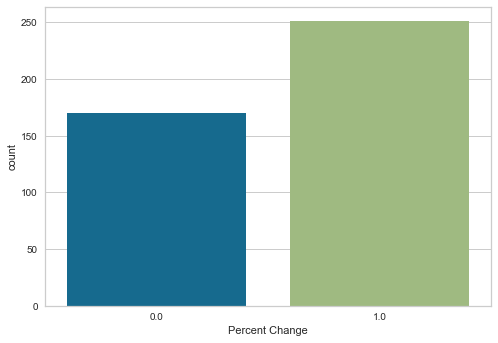

In [143]:
import seaborn as sns
import pandas as pd
sns.countplot(x = 'Percent Change',data = tweets_data)
tweets_data['Percent Change'].value_counts()[1.0] / (tweets_data['Percent Change'].value_counts()[1.0] + tweets_data['Percent Change'].value_counts()[0.0])

This means that our dataset is not balanced. It is slightly biased towards the 1.0 class.

Logistic Regression:

In [144]:


# tweets_train, train_y, tweets_test, test_y

lr = LogisticRegression(max_iter = 1000)


lr.fit(tweets_train,train_y)
y_pred_train =lr.predict(tweets_train)
y_pred =lr.predict(tweets_test)

cnf_matrix = confusion_matrix(test_y, y_pred)
trainAcc = accuracy_score(train_y, y_pred_train)
testAcc = accuracy_score(test_y, y_pred)
clf_rep = classification_report(test_y, y_pred)
print("test accuracy:", testAcc)
print(clf_rep)

test accuracy: 0.5647058823529412
              precision    recall  f1-score   support

         0.0       1.00      0.05      0.10        39
         1.0       0.55      1.00      0.71        46

    accuracy                           0.56        85
   macro avg       0.78      0.53      0.41        85
weighted avg       0.76      0.56      0.43        85



Text(0.5, 352.48, 'Predicted label')

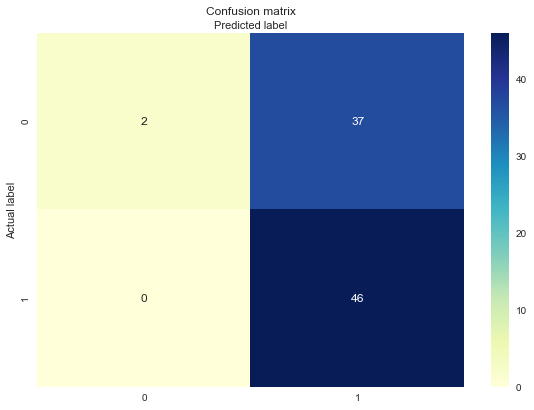

In [145]:
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

# Based on the heatmap our logistic regression model is pretty much always guessing it is always positive
# Although we are getting slightly higher than absolute guessing 63% > 59%

Decision Tree Classifier:

In [146]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
from sklearn.metrics import f1_score, make_scorer

import pydotplus
# tweets_train, train_y, tweets_test, test_y

clf = DecisionTreeClassifier()

clf = clf.fit(tweets_train, train_y)
y_pred_train = clf.predict(tweets_train)
y_pred = clf.predict(tweets_test)

# 5 fold cross validation
scores = cross_val_score(clf, tweets_train, train_y, cv = 5, scoring = 'f1')
print(scores.mean()) # should be as close to 1 as possible

0.6089058166838335


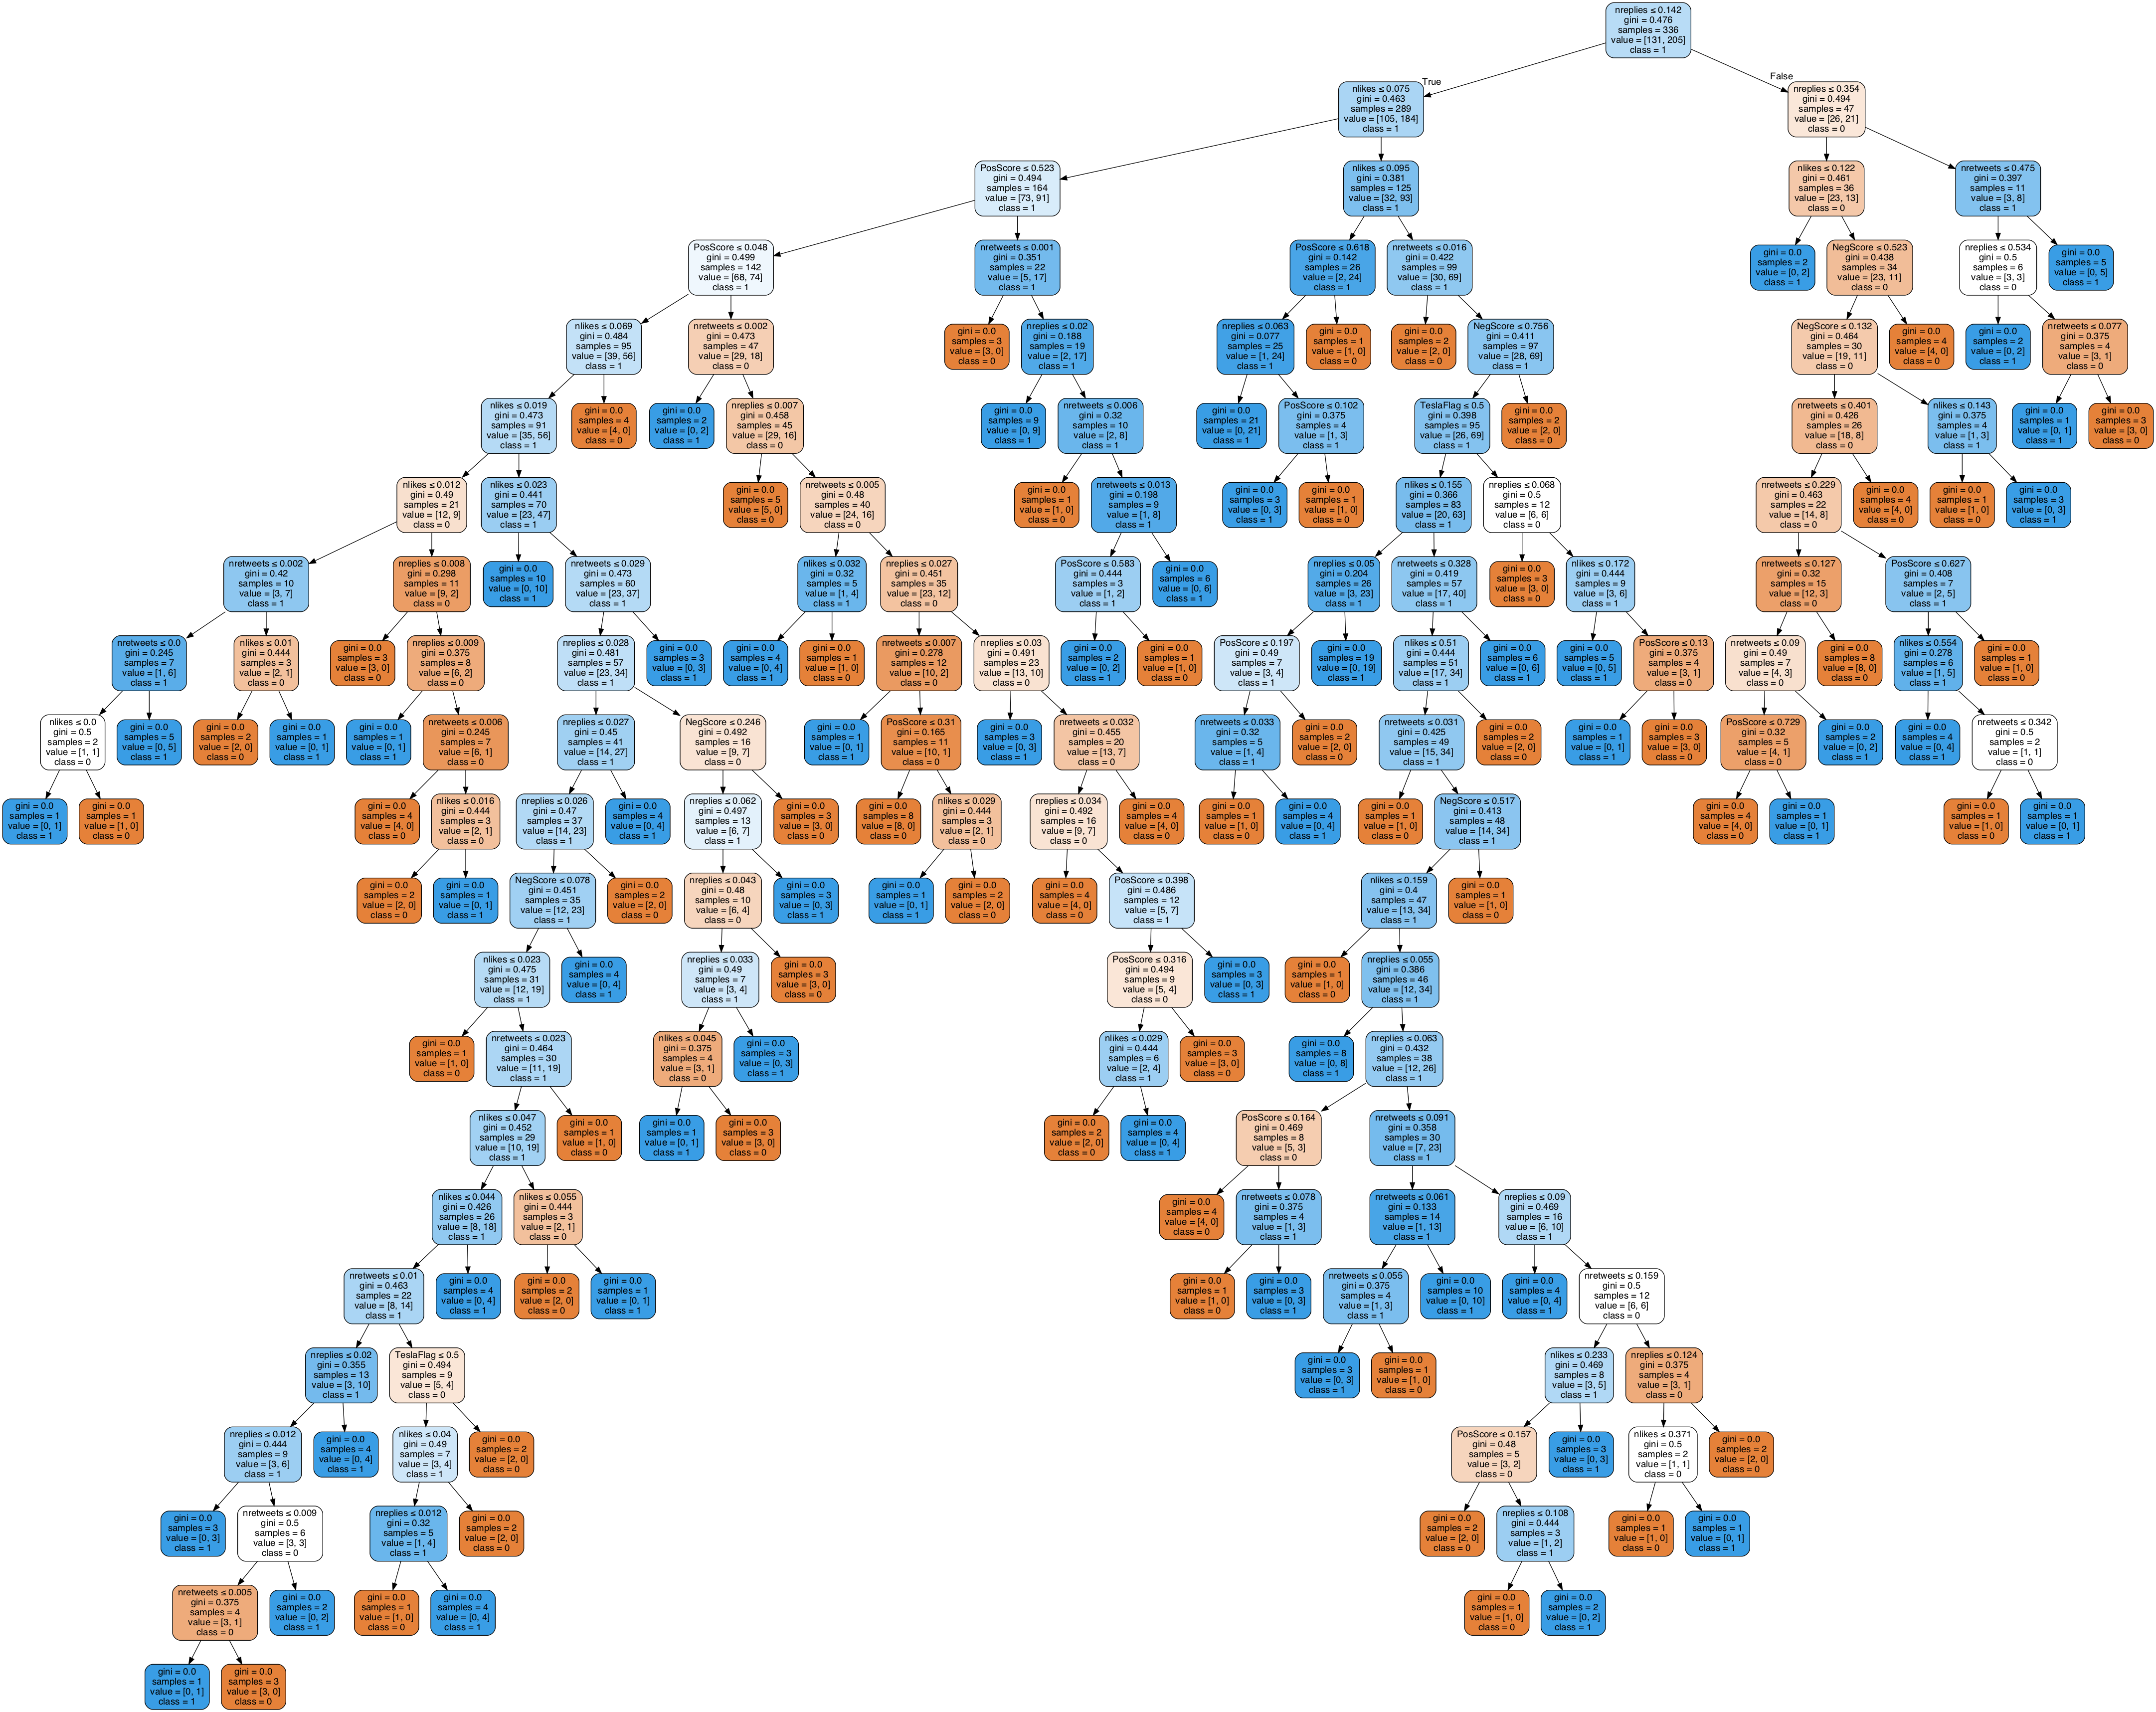

In [147]:
#Graph untuned Decision Tree (This is an overfitted tree) it covers every data point
feature_cols = ['nlikes','nreplies','nretweets','TeslaFlag','NegScore','PosScore']

dot_data = StringIO()
export_graphviz(clf, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True, feature_names = feature_cols,class_names=['0','1'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png('tree.png')
Image(graph.create_png())

In [148]:
print('f1 score on training data: ',f1_score(y_pred_train, train_y))
print('f1 score on testing data: ',f1_score(y_pred, test_y))
print("Test Accuracy:", accuracy_score(test_y, y_pred))
print("Test Precision:", precision_score(test_y, y_pred))
print("Test Recall:", recall_score(test_y, y_pred))

#Sign of completely overfit tree

f1 score on training data:  1.0
f1 score on testing data:  0.5858585858585859
Test Accuracy: 0.5176470588235295
Test Precision: 0.5471698113207547
Test Recall: 0.6304347826086957


In [149]:
parameters = {'max_depth':[3,4,5], 'min_samples_leaf':[1,2,3,4,5],
             'min_samples_split':[2,3,4,5], 'criterion':['gini','entropy']}
scorer = make_scorer(accuracy_score)

grid_object = GridSearchCV(clf, parameters, scoring = scorer)
grid_fit = grid_object.fit(tweets_train, train_y)

best_clf = grid_fit.best_estimator_
best_clf

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=3, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

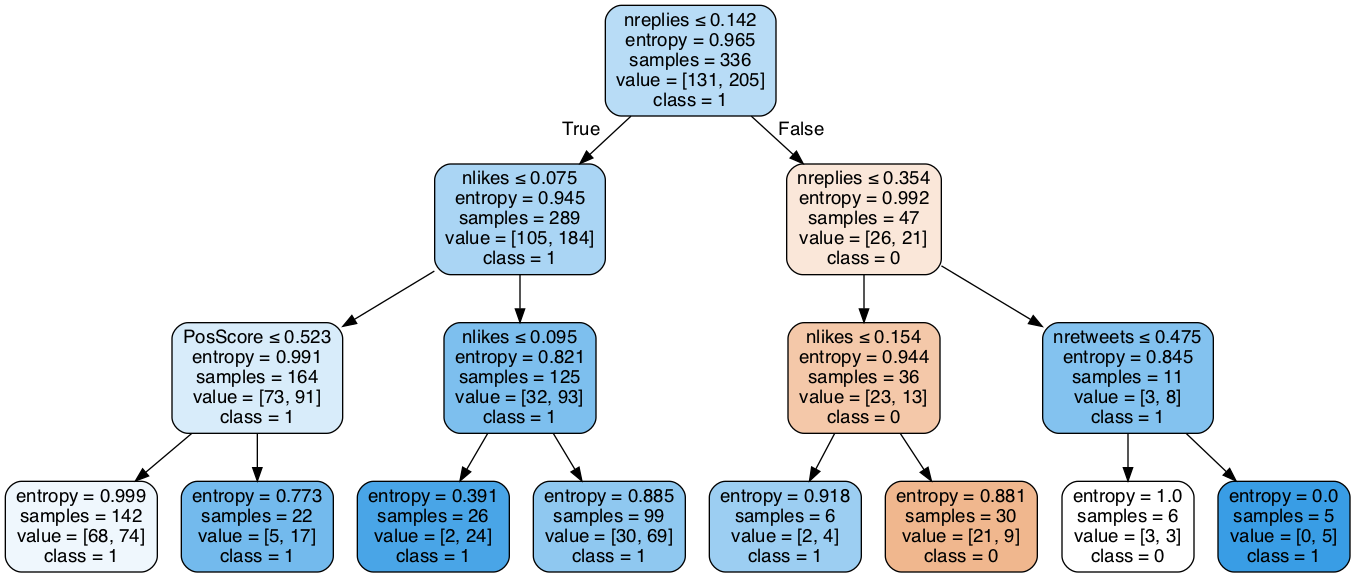

In [150]:
# Decision Tree after hyperparameter tuning

dot_data = StringIO()
export_graphviz(best_clf, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True, feature_names = feature_cols,class_names=['0','1'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png('tree.png')
Image(graph.create_png())

/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


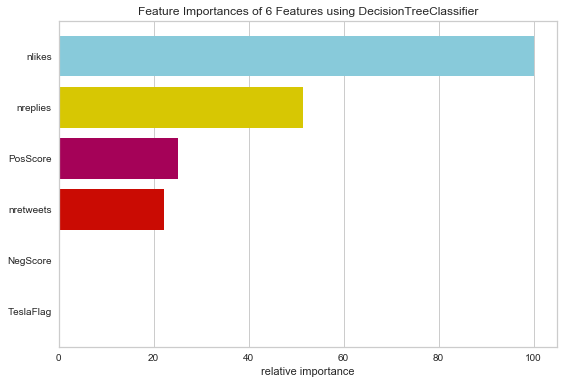

In [151]:
from yellowbrick.features import FeatureImportances
viz = FeatureImportances(best_clf)
viz.fit(tweets_train, train_y)
viz.poof()

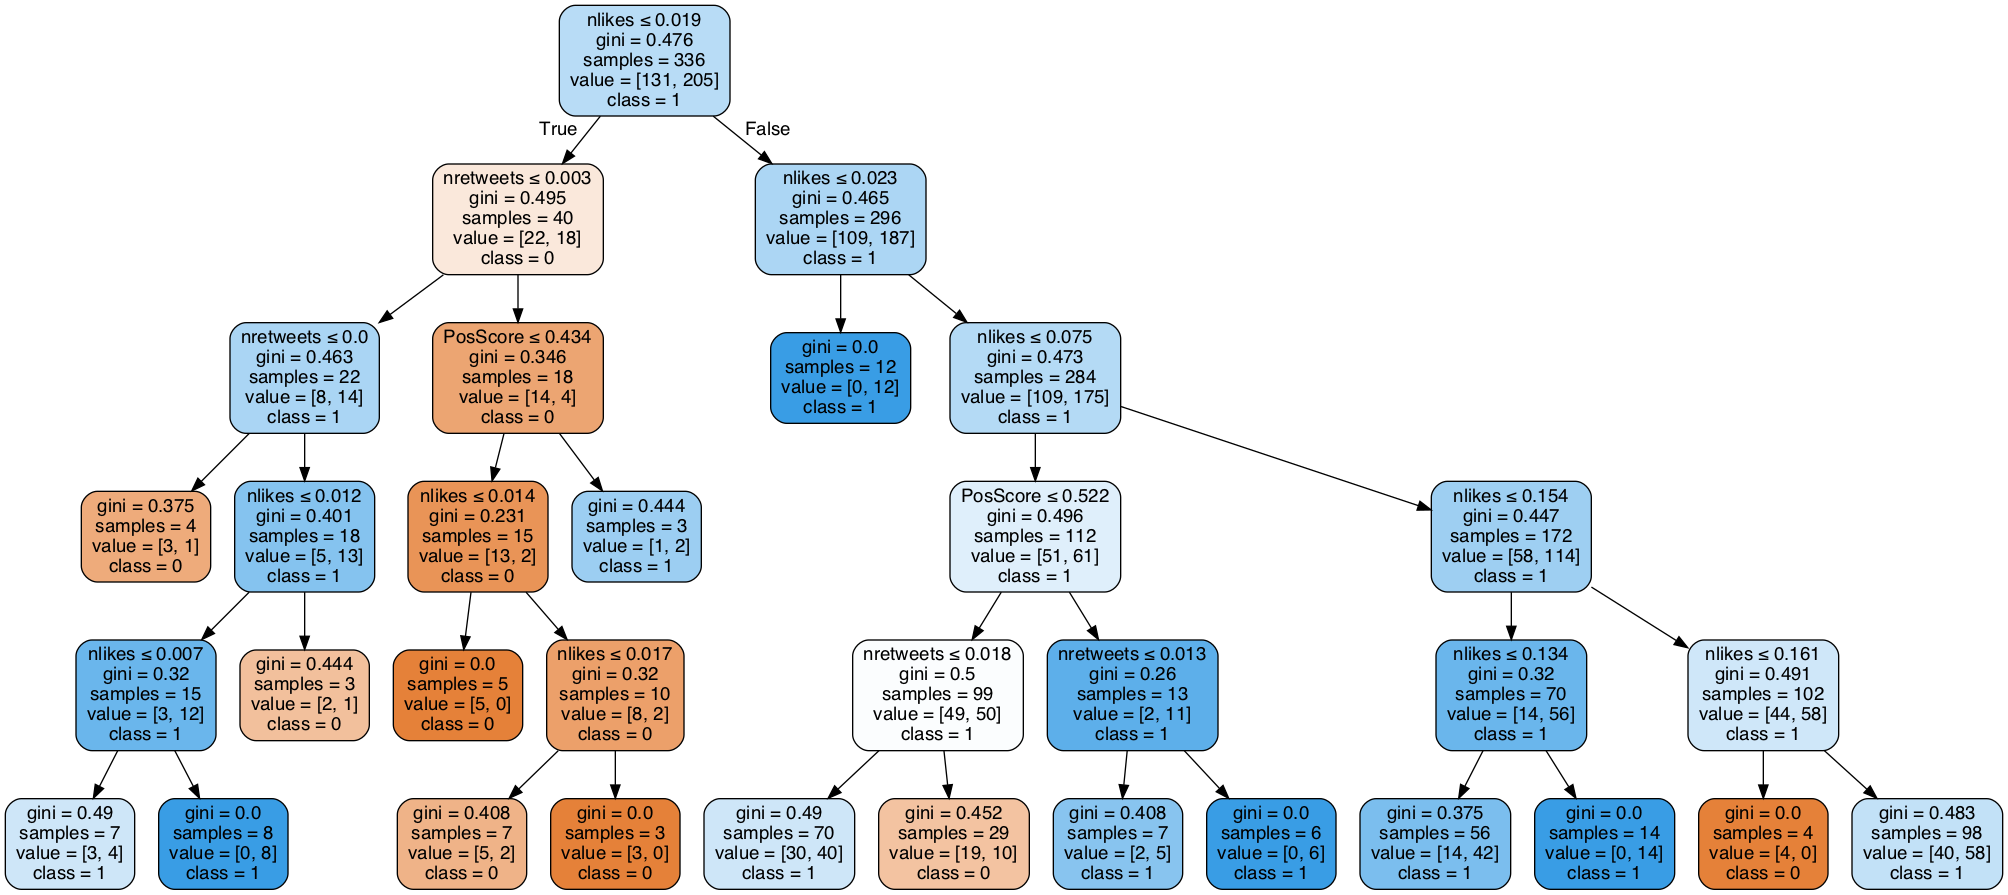

In [152]:
# Decision Tree after hyperparameter tuning and only important features included

best_features = tweets_train.drop(["TeslaFlag","nreplies"], axis = 1)
best_features_test = tweets_test.drop(["TeslaFlag","nreplies"], axis = 1)
grid_object = GridSearchCV(clf, parameters, scoring = scorer)
grid_fit = grid_object.fit(best_features, train_y)
best_clf = grid_fit.best_estimator_

feature_cols_important = ['nlikes','nretweets','NegScore','PosScore']

dot_data = StringIO()
export_graphviz(best_clf, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True, feature_names = feature_cols_important,class_names=['0','1'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png('tree.png')
Image(graph.create_png())

In [191]:
# Metrics with hyperparameter tuning and only important features included

best_clf = best_clf.fit(best_features, train_y)
best_y_pred_train = best_clf.predict(best_features)
best_y_pred = best_clf.predict(best_features_test)

print('f1 score on training data: ',f1_score(train_y, best_y_pred_train))
print('f1 score on testing data: ',f1_score(test_y, best_y_pred ))
print("Test Accuracy:", accuracy_score(test_y, best_y_pred))
print("Test Precision:", precision_score(test_y, best_y_pred))
print("Test Recall:", recall_score(test_y, best_y_pred))

scores = cross_val_score(best_clf, best_features, train_y, cv = 5, scoring = 'f1')
print("CV score", scores.mean()) # should be as close to 1 as possible

f1 score on training data:  0.7860082304526749
f1 score on testing data:  0.6842105263157895
Test Accuracy: 0.5764705882352941
Test Precision: 0.5735294117647058
Test Recall: 0.8478260869565217
CV score 0.7153417634023147


In [154]:
# Metrics after only hyperparameter tuning

best_clf = best_clf.fit(tweets_train, train_y)
best_y_pred_train = best_clf.predict(tweets_train)
best_y_pred = best_clf.predict(tweets_test)

print('f1 score on training data: ',f1_score(best_y_pred_train, train_y))
print('f1 score on testing data: ',f1_score(best_y_pred, test_y))
print("Test Accuracy:", accuracy_score(test_y, best_y_pred))
print("Test Precision:", precision_score(test_y, best_y_pred))
print("Test Recall:", recall_score(test_y, best_y_pred))

scores = cross_val_score(best_clf, tweets_train, train_y, cv = 5, scoring = 'f1')
print("CV score", scores.mean()) # should be as close to 1 as possible

f1 score on training data:  0.7855530474040632
f1 score on testing data:  0.5904761904761905
Test Accuracy: 0.49411764705882355
Test Precision: 0.5254237288135594
Test Recall: 0.6739130434782609
CV score 0.6707532861476239


The only difference when we used feature importance in selecting the columns for the decision tree was a slight increase in 5 fold cross validation score, meaning it will perform better on new data which is valuable. 

Our Accuracy went up from 0.55 to 0.63 and the f1 score moved closer to 1 after hyperparemeter tuning. Additionaly our Recall is very high after tuning, suggesting that a high proportion of positives were identified correctly. The problem here is that our decision tree defaults to grouping most of our data into class 1 (visually this is leaf 4 from the left on our hyperparameter tuned decision tree. This is the reason we choose not to move forward with a random forrest; each decision tree will usually predict a given datapoint to be positive, so an ensemble of decision trees would not provide much value here. 

Feature Analysis:

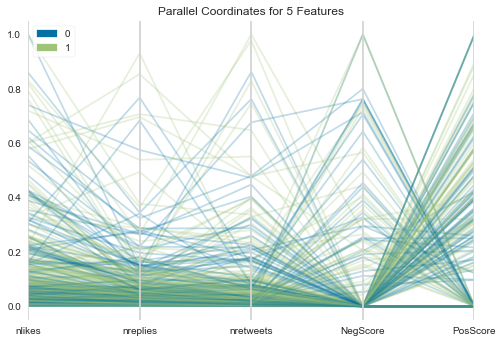

In [155]:
from yellowbrick.features import ParallelCoordinates

# Select a handful of relevant columns and drop nulls.
np.random.seed()
parallel_analysis = tweets_train.drop(["TeslaFlag"], axis = 1)

# Fit the chart.
# fig, ax = plt.subplots(1, figsize=(12, 6))
kwargs = {'vlines_kwds': {'color': 'lightgray'}}
vzr = ParallelCoordinates(classes=[0, 1], **kwargs)  # ax=ax
vzr.fit(parallel_analysis, train_y)
vzr.transform(parallel_analysis)
sns.despine(left=True, bottom=True)

# Display.
vzr.poof()

We don't see many significant outliers, but we can see that for nlikes, nreplies, nretweets most of the data is bunched up very close together (< 0.3 on this normalized scale)

We also notice that much more of the NegScore values are at 0 than the PosScore values. Meaning that the tweets are typically not negative

KNN Classifier:

In [206]:
# tweets_train, train_y, tweets_test, test_y

scores = {}
scores_list = []
for k in range(1,51):
    model = KNeighborsClassifier(n_neighbors=k)
    model.fit(tweets_train,train_y)
    y_pred = model.predict(tweets_test)
    scores[k] = accuracy_score(test_y, y_pred)
    scores_list.append(accuracy_score(test_y, y_pred))

print(scores)

{1: 0.5176470588235295, 2: 0.5764705882352941, 3: 0.5647058823529412, 4: 0.5882352941176471, 5: 0.5529411764705883, 6: 0.5411764705882353, 7: 0.5294117647058824, 8: 0.49411764705882355, 9: 0.5529411764705883, 10: 0.5647058823529412, 11: 0.5647058823529412, 12: 0.5882352941176471, 13: 0.6, 14: 0.5882352941176471, 15: 0.5764705882352941, 16: 0.5647058823529412, 17: 0.5294117647058824, 18: 0.5411764705882353, 19: 0.5294117647058824, 20: 0.5176470588235295, 21: 0.5411764705882353, 22: 0.5294117647058824, 23: 0.5647058823529412, 24: 0.5411764705882353, 25: 0.5529411764705883, 26: 0.5176470588235295, 27: 0.5764705882352941, 28: 0.5294117647058824, 29: 0.5176470588235295, 30: 0.5294117647058824, 31: 0.5411764705882353, 32: 0.5176470588235295, 33: 0.5176470588235295, 34: 0.5058823529411764, 35: 0.5176470588235295, 36: 0.5058823529411764, 37: 0.5411764705882353, 38: 0.5176470588235295, 39: 0.5294117647058824, 40: 0.5411764705882353, 41: 0.5411764705882353, 42: 0.5294117647058824, 43: 0.54117647

Text(0, 0.5, 'Testing Accuracy')

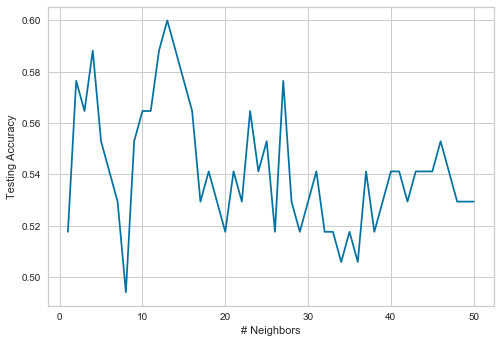

In [207]:
#plot num neighbors vs accuracy
plt.plot(range(1,51), scores_list)
plt.xlabel('# Neighbors')
plt.ylabel('Testing Accuracy')

# We see a peak at k = 13

In [208]:
best_KNN = KNeighborsClassifier(n_neighbors = 13)
best_KNN.fit(tweets_train,train_y)
best_y_pred = best_KNN.predict(tweets_test)

print("Test Accuracy:", accuracy_score(test_y, best_y_pred))
print("Test Precision:", precision_score(test_y, best_y_pred))
print("Test Recall:", recall_score(test_y, best_y_pred))
print('Test f1: ',f1_score(test_y, best_y_pred))

Test Accuracy: 0.6
Test Precision: 0.5909090909090909
Test Recall: 0.8478260869565217
Test f1:  0.6964285714285714


We have reached a peak accuracy of 0.6 for our KNN algorithm. This is lower than all of our other supervised algorithms, so we would not move forward with the implementation of this algorithm. From the #Neighbors vs Accuracy graph above we can see that KNN is not the right choice here because we see a lot of randomness in our graph, signaling no real relationship between number of neighbors and accuracy.

Support Vector Classifier:

In [209]:
clf = svm.SVC(kernel='linear')
clf.fit(tweets_train, train_y)
y_pred = clf.predict(tweets_test)

print("Test Accuracy:", accuracy_score(test_y, y_pred))
print("Test Precision:", precision_score(test_y, y_pred))
print("Test Recall:", recall_score(test_y, y_pred))
print('Test f1: ',f1_score(test_y, y_pred))

print(classification_report(test_y, y_pred))

Test Accuracy: 0.5411764705882353
Test Precision: 0.5411764705882353
Test Recall: 1.0
Test f1:  0.7022900763358779
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        39
         1.0       0.54      1.00      0.70        46

    accuracy                           0.54        85
   macro avg       0.27      0.50      0.35        85
weighted avg       0.29      0.54      0.38        85



/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Based on the Classification Report we see that we are always guessing 1 as our class! Maybe we can fix this by tuning parameters.

In [210]:
# Hyperparameter Tuning
# defining parameter range 
param_grid = {'C': [0.1, 1, 10, 100, 1000],  
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 
              'kernel': ['rbf']}  
  
grid = GridSearchCV(svm.SVC(), param_grid, refit = True, verbose = 1) 
  
# fitting the model for grid search 
grid.fit(tweets_train, train_y)

Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:    0.8s finished


GridSearchCV(cv=None, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['rbf']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=1)

In [211]:
print(grid.best_params_) 


{'C': 0.1, 'gamma': 1, 'kernel': 'rbf'}


In [214]:
grid_pred = grid.predict(tweets_test)

print("Test Accuracy:", accuracy_score(test_y, grid_pred))
print("Test Precision:", precision_score(test_y, grid_pred))
print("Test Recall:", recall_score(test_y, grid_pred))
print('Test f1: ',f1_score(test_y, grid_pred))

print(classification_report(test_y, grid_pred))

Test Accuracy: 0.5411764705882353
Test Precision: 0.5411764705882353
Test Recall: 1.0
Test f1:  0.7022900763358779
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        39
         1.0       0.54      1.00      0.70        46

    accuracy                           0.54        85
   macro avg       0.27      0.50      0.35        85
weighted avg       0.29      0.54      0.38        85



/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


The best kernel was rbf and we also set the gamma and C value using tuning.

We still get the exact same performance metrics after tuning, because the SVM classifier consistently gets the best results when always predicting the class to be 1.0. SVM is not viable on our dataset as it cannot find a classifier using support vectors that does any better than just choosing 1 every time.